# ТРАНСКРИПТОМИКА  (Июль 2021 г.)
---

Получите все необходимые переменные из практики №2:

In [23]:
library("tximeta")
library("DESeq2")
dir <- '/home/prep/Transcriptomics/data_practice2/'
csvfile <- file.path(dir, "sample_table.csv")
coldata <- read.csv(csvfile, row.names=1, stringsAsFactors=FALSE)
coldata <- coldata[1:8,]
coldata$names <- coldata$Run
coldata$files <- file.path(dir, "quants", coldata$names, "quant.sf")
file.exists(coldata$files)
se <- tximeta(coldata)
gse <- summarizeToGene(se)
dds <- DESeqDataSet(gse, design = ~ cell + dex)
keep <- rowSums(counts(dds) >= 10) >= 3
dds <- dds[keep,]
vsd <- vst(dds, blind = FALSE)
rld <- rlog(dds, blind = FALSE)
dds <- estimateSizeFactors(dds)

[1] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE

importing quantifications

reading in files with read_tsv

1 
2 
3 
4 
5 
6 
7 
8 


found matching transcriptome:
[ GENCODE - Homo sapiens - release 38 ]

loading existing TxDb created: 2021-07-08 12:28:34

loading existing transcript ranges created: 2021-07-08 12:28:36

fetching genome info for GENCODE

loading existing TxDb created: 2021-07-08 12:28:34

obtaining transcript-to-gene mapping from database

loading existing gene ranges created: 2021-07-08 12:28:50

summarizing abundance

summarizing counts

summarizing length

summarizing inferential replicates

using counts and average transcript lengths from tximeta

Warning message in DESeqDataSet(gse, design = ~cell + dex):
"some variables in design formula are characters, converting to factors"
using 'avgTxLength' from assays(dds), correcting for library size

using 'avgTxLength' from assays(dds), correcting for library size

using 'avgTxLength' from assays(dds), correcting for library size





## ПРАКТИКА 3. Дифференциальная экспрессия генов

3.1. Дифференциальное выражение значений TPM<br>
3.2. Графическое отображение результатов дифференциальной экспрессии по отдельным генам<br>
3.3. Графическое отображение результатов дифференциальной экспрессии по всем генам<br>
3.4. Кластеризация генов с дифференциальной экспрессией<br>
3.5. Аннотация дифференциально экспрессируемых генов<br>
3.6. Анализ результатов с учетом аннотации генов<br>

---

## 3.1. Дифференциальное выражение значений TPM

Подготовка файла для дифференциальной экспрессии генов. Программа DESeq делает оценку факторов размера с учетом различий в глубине секвенирования образцов, оценку значений дисперсии для каждого гена, подбор обобщенной линейной модели и т.д.

In [24]:
dds <- DESeq(dds)

using pre-existing normalization factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [25]:
colData(dds)

DataFrame with 8 rows and 10 columns
            SampleName     cell      dex       albut         Run avgLength
           <character> <factor> <factor> <character> <character> <integer>
SRR1039508  GSM1275862  N61311     untrt       untrt  SRR1039508       126
SRR1039509  GSM1275863  N61311     trt         untrt  SRR1039509       126
SRR1039512  GSM1275866  N052611    untrt       untrt  SRR1039512       126
SRR1039513  GSM1275867  N052611    trt         untrt  SRR1039513        87
SRR1039516  GSM1275870  N080611    untrt       untrt  SRR1039516       120
SRR1039517  GSM1275871  N080611    trt         untrt  SRR1039517       126
SRR1039520  GSM1275874  N061011    untrt       untrt  SRR1039520       101
SRR1039521  GSM1275875  N061011    trt         untrt  SRR1039521        98
            Experiment      Sample    BioSample       names
           <character> <character>  <character> <character>
SRR1039508   SRX384345   SRS508568 SAMN02422669  SRR1039508
SRR1039509   SRX384346   SRS50856

Подготовка данных с результатами анализа между обработанными (trt) и необработанными (untrt) клетками и вывод результата

In [26]:
res <- results(dds, contrast=c("dex","trt","untrt"))
res

log2 fold change (MLE): dex trt vs untrt 
Wald test p-value: dex trt vs untrt 
DataFrame with 17920 rows and 6 columns
                    baseMean log2FoldChange     lfcSE      stat      pvalue
                   <numeric>      <numeric> <numeric> <numeric>   <numeric>
ENSG00000000003.15  748.9578     -0.4827636 0.1210142 -3.989314 6.62647e-05
ENSG00000000419.14  592.5404      0.1891330 0.1245799  1.518166 1.28973e-01
ENSG00000000457.14  317.0718      0.0274886 0.1553760  0.176917 8.59574e-01
ENSG00000000460.17   83.2139     -0.1668404 0.3098174 -0.538512 5.90224e-01
ENSG00000000971.16 5824.4693      0.4423443 0.0910655  4.857430 1.18919e-06
...                      ...            ...       ...       ...         ...
ENSG00000288709.1   139.2223       0.405908  0.241376  1.681639   0.0926388
ENSG00000288710.1    17.9707      -0.449790  0.533040 -0.843820   0.3987699
ENSG00000288720.1    12.7158      -0.791351  0.656523 -1.205367   0.2280617
ENSG00000288721.1    24.8598      -0.924534  

**baseMean** - среднее значение нормализованных значений числа ридов (count), разделенное на коэффициент размера, взятые для всех выборок в DESeqDataSet.<br/> 
**log2FoldChange** - разница в экспрессии гена в результате обработки клеток дексаметазоном по сравнению с необработанными образцами. Это значение отображается в логарифмической шкале с основанием 2. Например, изменение в 1,5 раза в логарифмическом масштабе означает, что экспрессия гена увеличивается на множитель 21,5, т.е. 2,82.<br/> 
**lfcSE** - оценка стандартной ошибки для оценки log2-кратного изменения. 
DESeq2 выполняет для каждого гена проверку гипотезы, чтобы увидеть, достаточно ли доказательств, чтобы принять решение против нулевой гипотезы о том, что существует нулевой эффект лечения на ген и что наблюдаемая разница между лечением и контролем была просто вызвана экспериментальной вариабельностью (т.е. тип вариабельности, которую можно ожидать между разными образцами в одной и той же экспериментальной группе). При статистической разнице, **stat**, результат этого теста отображается как значение p и находится в столбце **pvalue**.<br/> 
**padj** - скорректированные pvalue методом Бенджамини-Хохберга (BH).

Для вывода дифференциально экспрессируемых генов с пороговым значенем padj в 0.05 и более, выведем таблицу:

In [27]:
res.05 <- results(dds, alpha = 0.05)
table(res.05$padj < 0.05)


FALSE  TRUE 
12858  3672 

Для увеличения порога дифференциальной экспрессии лучше использовать данные resLFC1, значения по шкале log2. Например, указав порог lfcThreshold = 1, мы проверяем гены, которые показывают значительное влияние на обработку дексаметазолом, более или менее чем в два раза. 

In [28]:
resLFC1 <- results(dds, lfcThreshold=1)
table(resLFC1$padj < 0.1)


FALSE  TRUE 
17707   213 

---

## 3.2. Графическое отображение результатов дифференциальной экспрессии по отдельным генам

Для визуализации генов с различным покрытием (count) используем функцию plotCounts, которая принимает в качестве аргументов матрицу DESeqDataSet, имя гена и группу, по которой строится график.

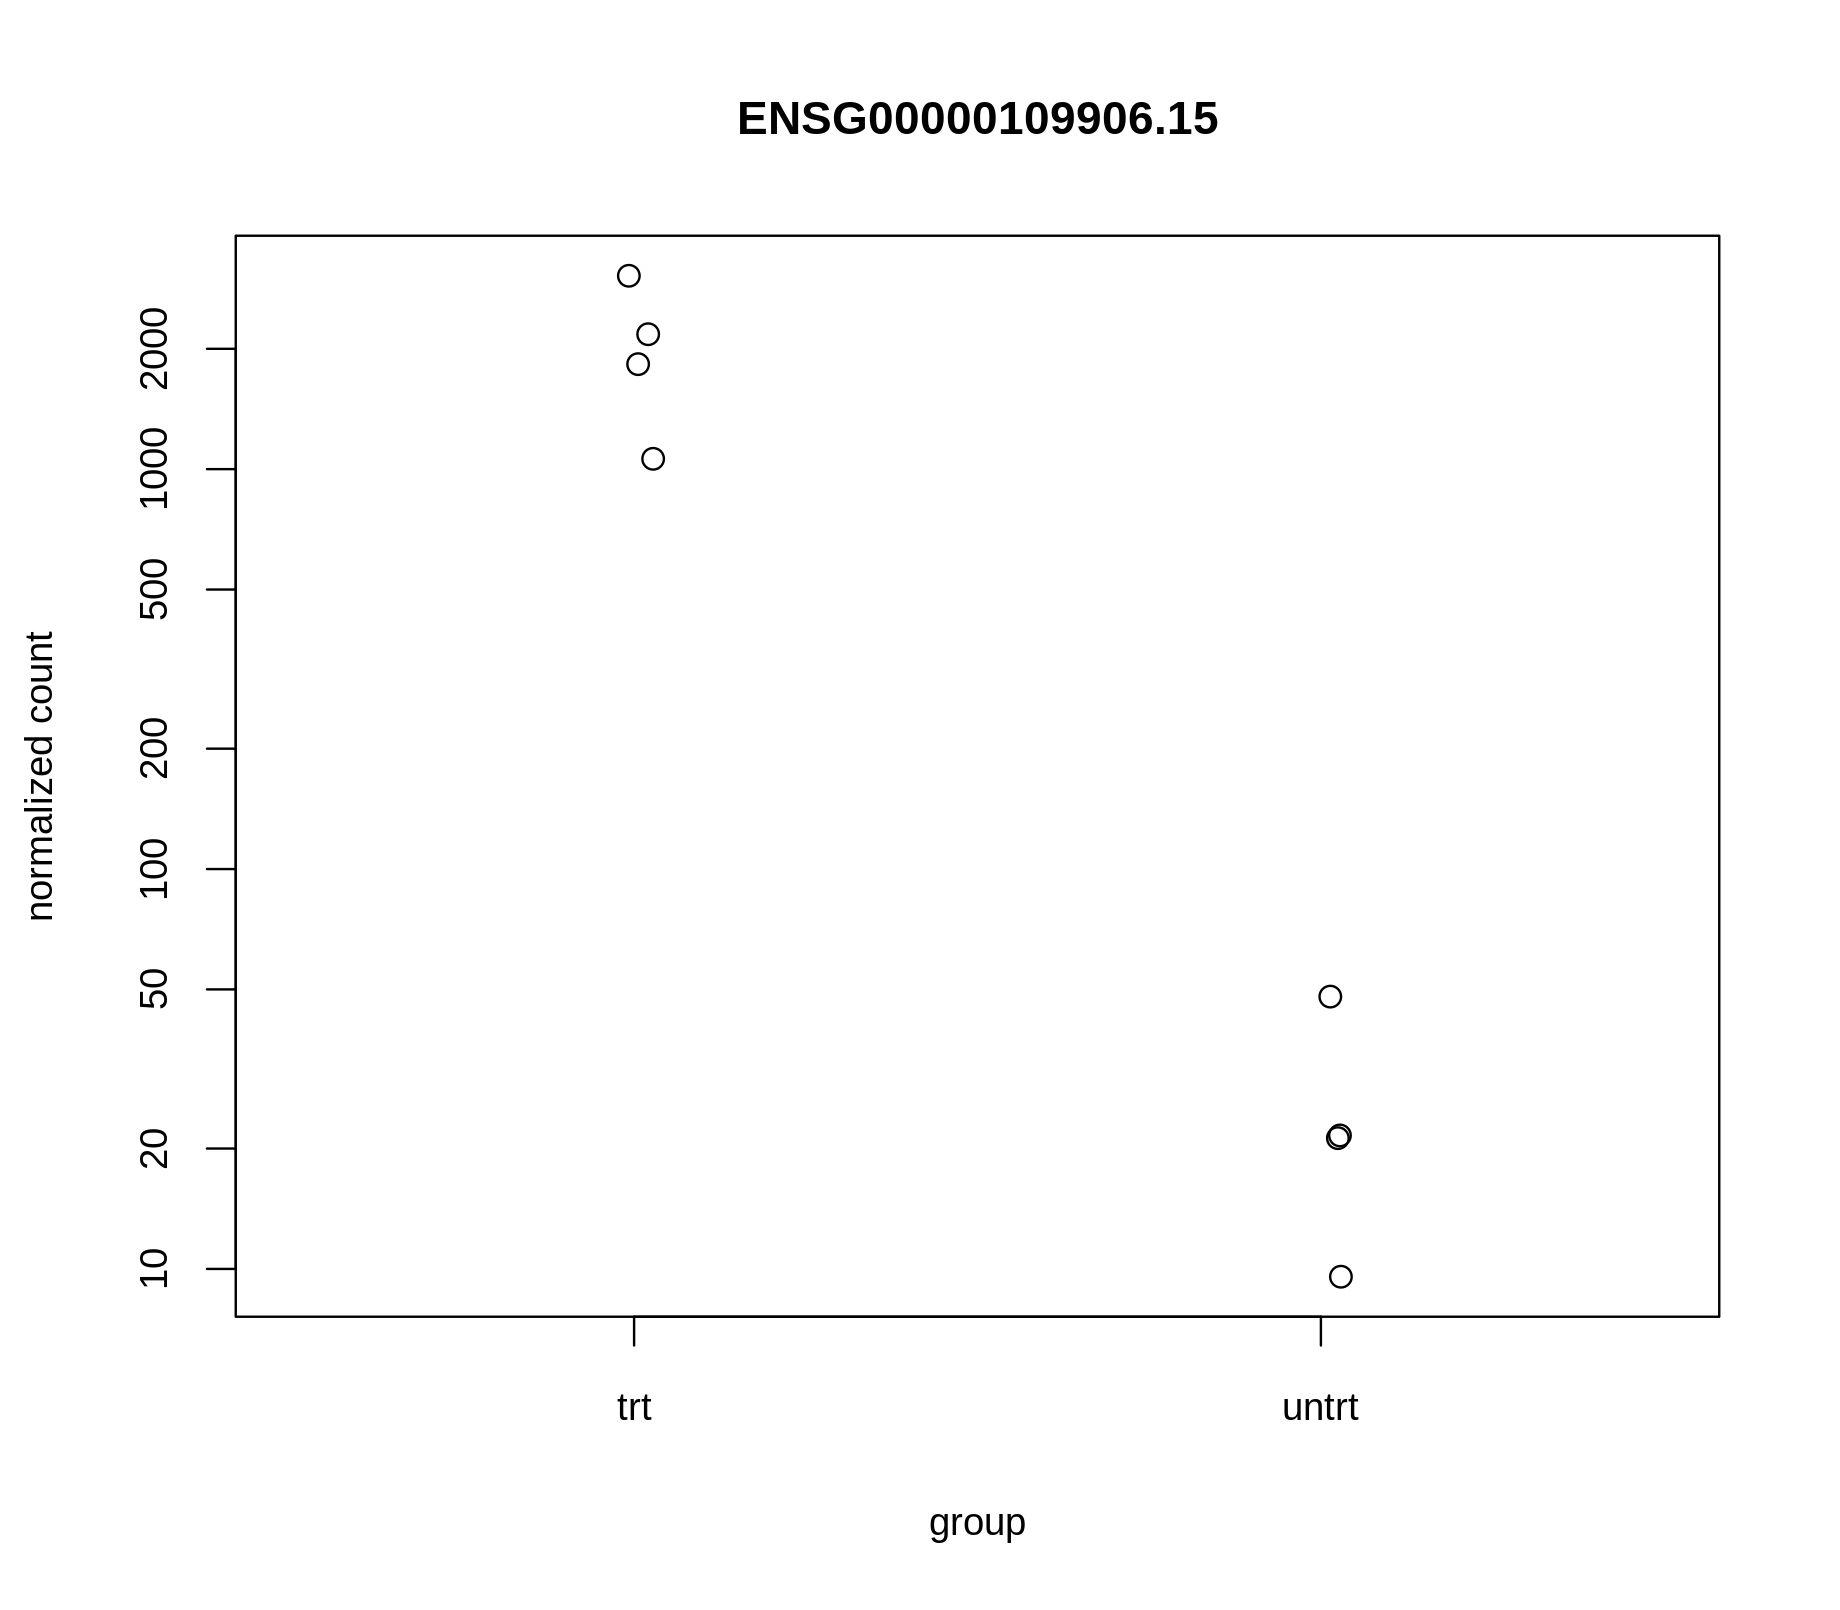

In [29]:
options(repr.plot.width=8, repr.plot.height=7, repr.plot.res=230, repr.plot.pointsize=15, repr.plot.quality=100)
topGene <- rownames(res)[which.min(res$padj)]
plotCounts(dds, gene = topGene, intgroup=c("dex"))

Подобный график с разбиением по каждому номеру клеток для гена CRISPLD2 (ENSG00000103196.12), который является ключевым для понимания влияния дексаметазола на клетки гладкой мышечной мускулатуры

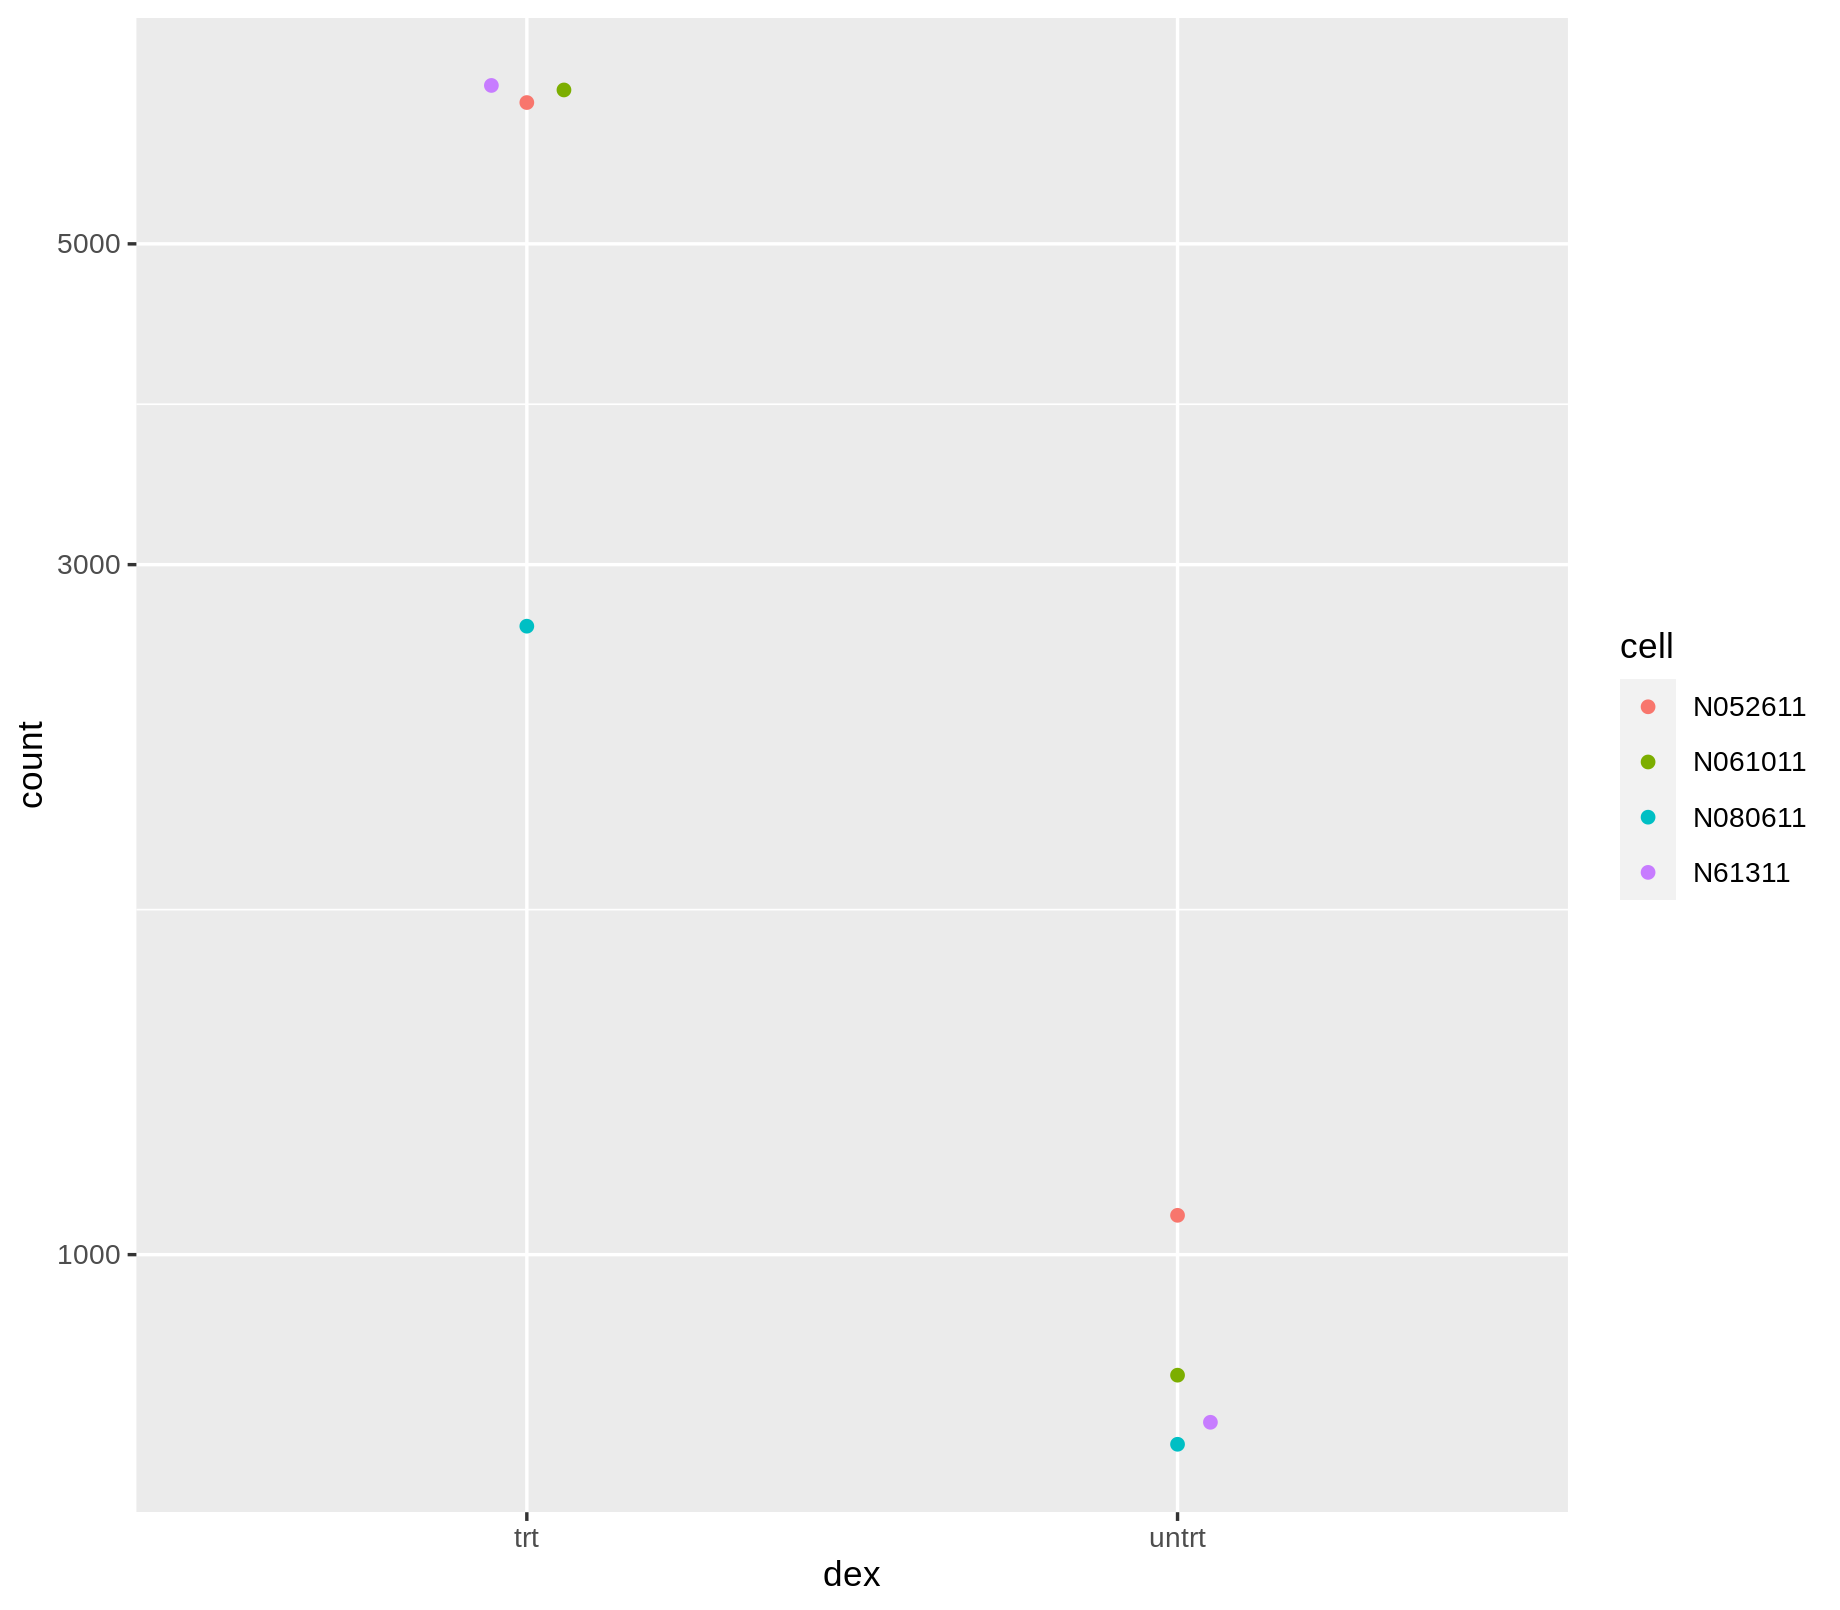

In [30]:
library("ggbeeswarm")
geneCounts <- plotCounts(dds, gene = "ENSG00000103196.12", intgroup = c("dex","cell"), returnData = TRUE)
ggplot(geneCounts, aes(x = dex, y = count, color = cell)) + scale_y_log10() +  geom_beeswarm(cex = 3)

### Задание № 1:

1) Постройте график для гена "ENSG00000204941.14"
2) Есть ли разница в экспрессии по этому гену между обработанными и необработанными дексаметозолом клетками?

**Ответы:**

1) Построим график:

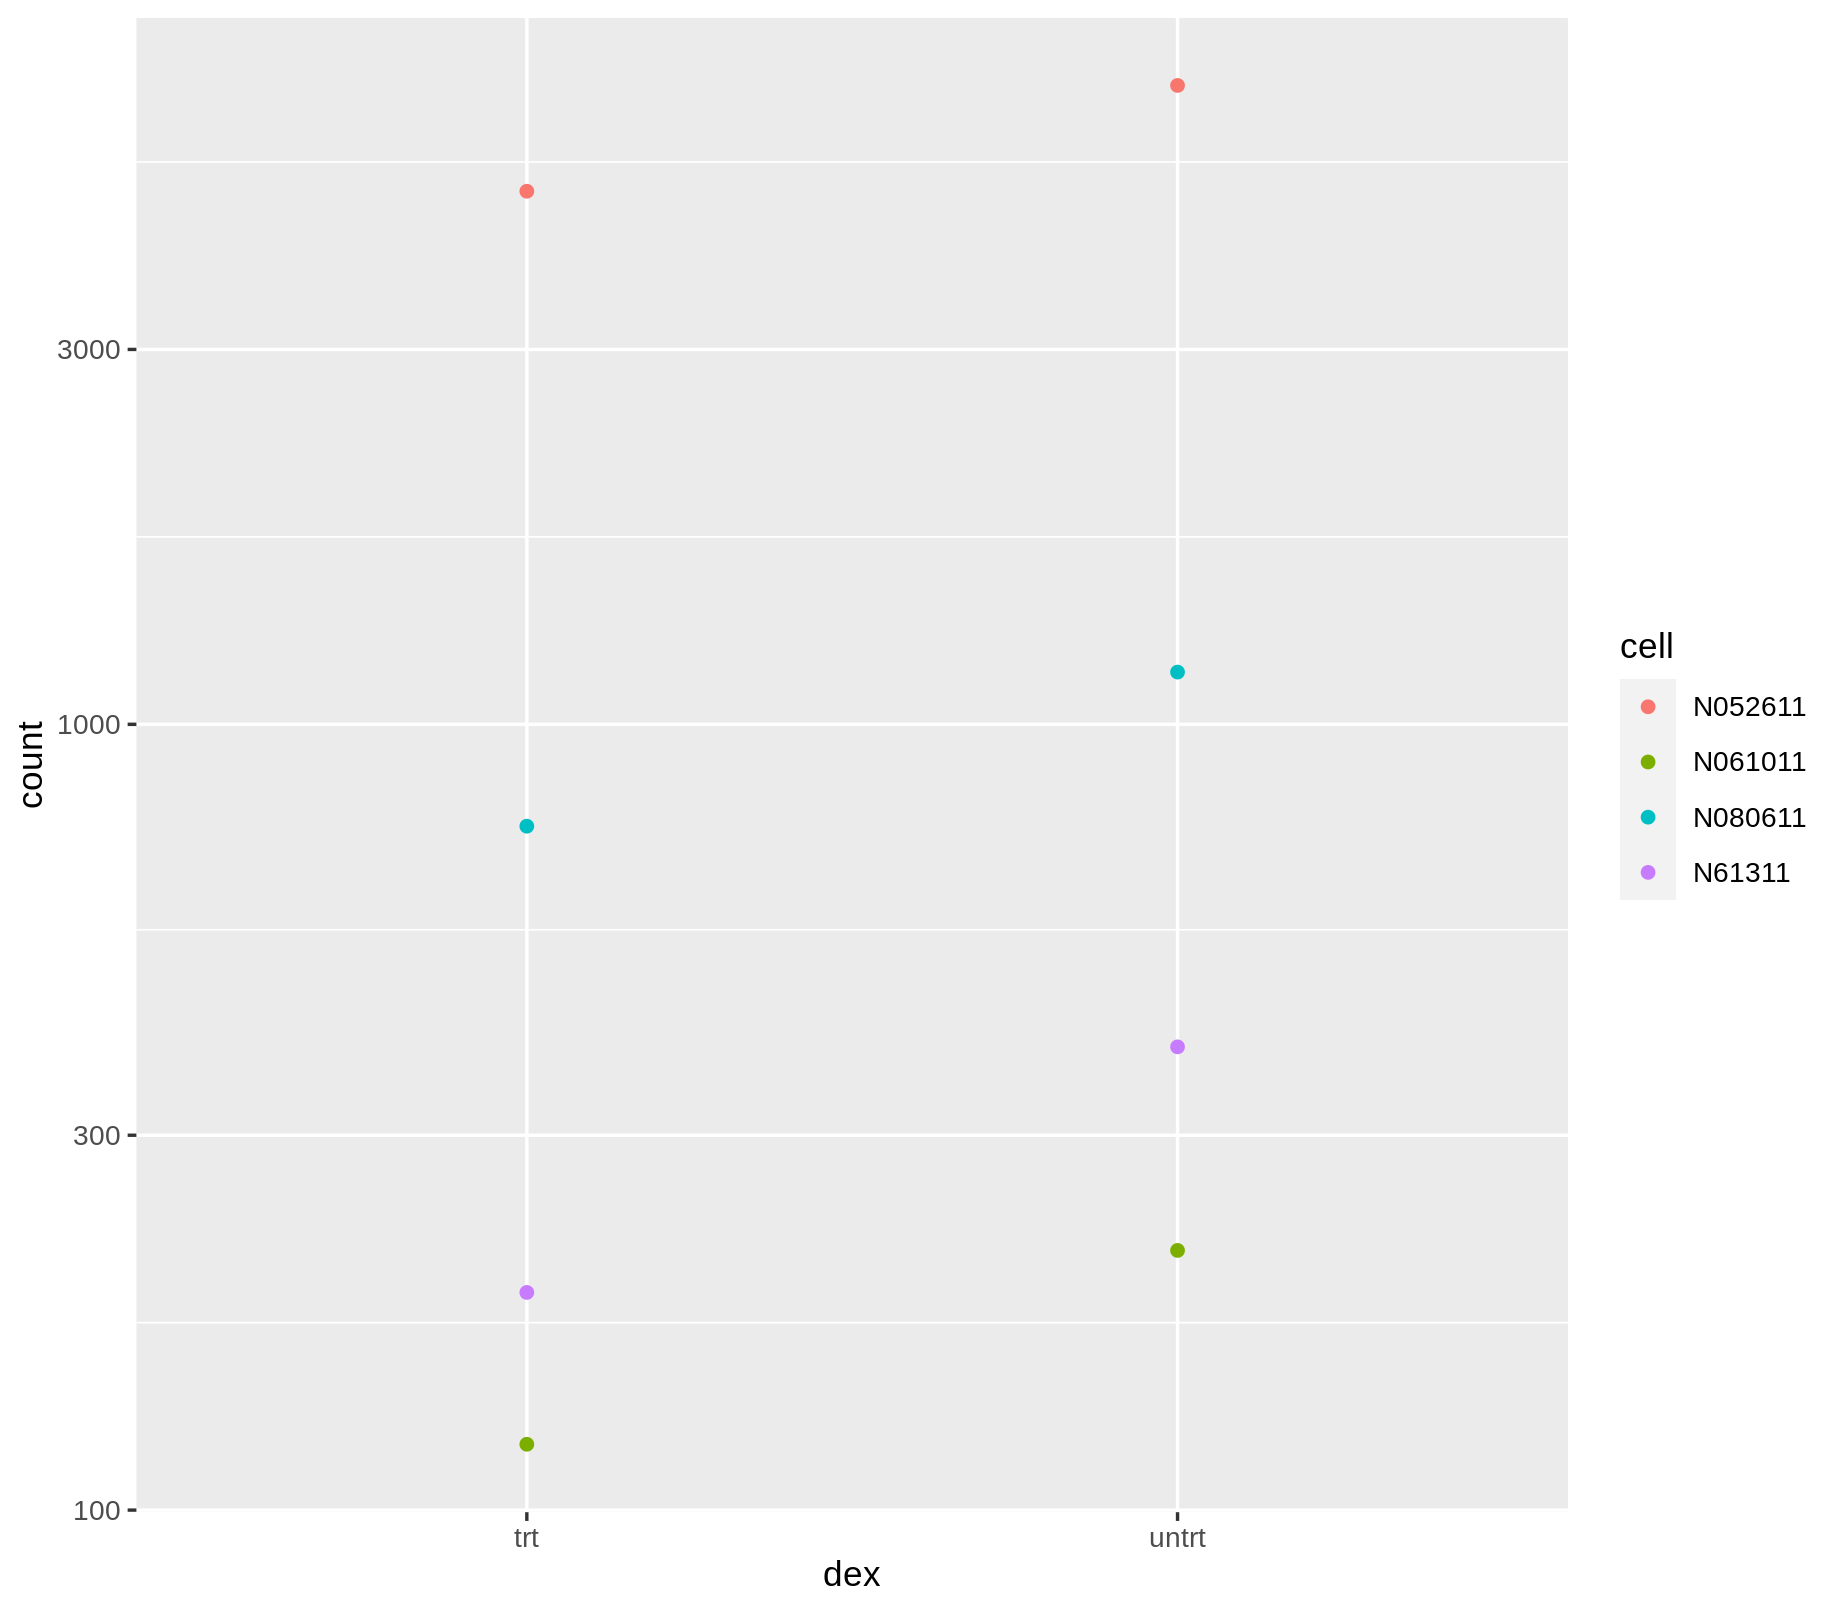

In [31]:
library("ggbeeswarm")
geneCounts <- plotCounts(dds, gene = "ENSG00000204941.14", intgroup = c("dex","cell"), returnData = TRUE)
ggplot(geneCounts, aes(x = dex, y = count, color = cell)) + scale_y_log10() +  geom_beeswarm(cex = 3)

2) Разница, пусть и небольшая, но все же имеется. Клеточные линии untrt (необработанные дексаметозолом) экспрессируются сильнее, чем обработанные.

---

## 3.3. Графическое отображение результатов дифференциальной экспрессии по всем генам

Следующий график показывает распределение значений log2FoldChange по всем генам. Логарифмическое двукратное изменение для конкретного сравнения нанесено на ось y, а среднее значение отсчетов, нормализованных по коэффициенту размера, показано на оси x. Значимо различающиеся гены обозначены синим цветом.
Перед построением MA-графика мы используем функцию lfcShrink, чтобы уменьшить log2-кратные изменения для сравнения обработанных и необработанных образцов. Мы использовали нормализацию методом apeglm, который применяется для сокращения стабилизации зашумленных оценок LFC. 

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



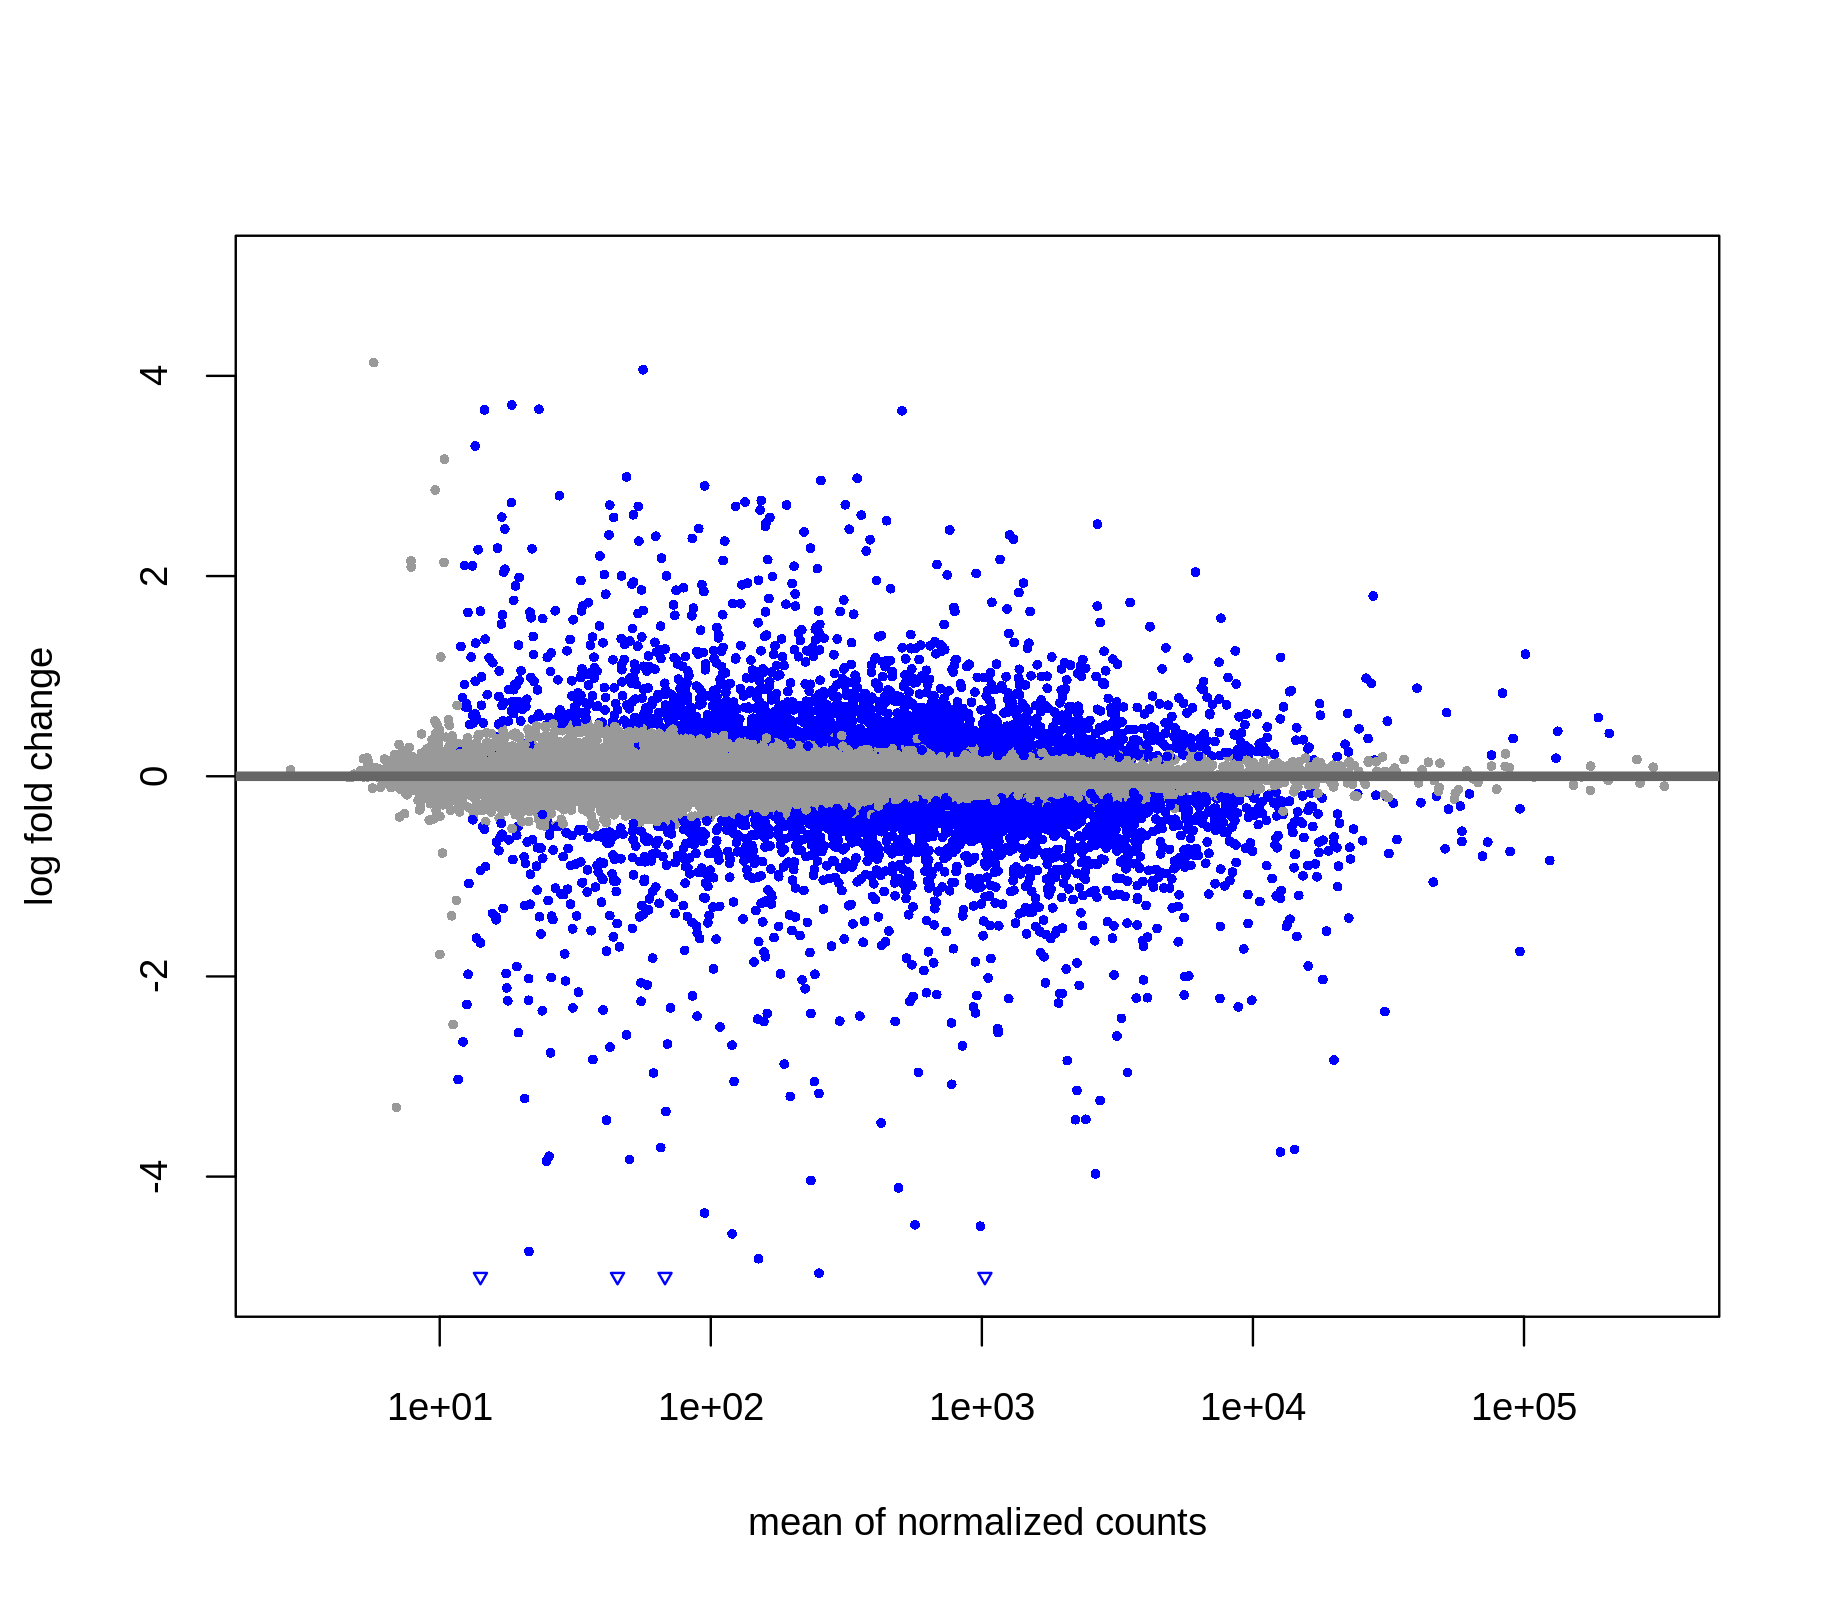

In [32]:
library("apeglm")
res <- lfcShrink(dds, coef="dex_untrt_vs_trt", type="apeglm")
plotMA(res, ylim = c(-5, 5))

Сходный график без нормализации методом lfcShrink будет иметь вид:

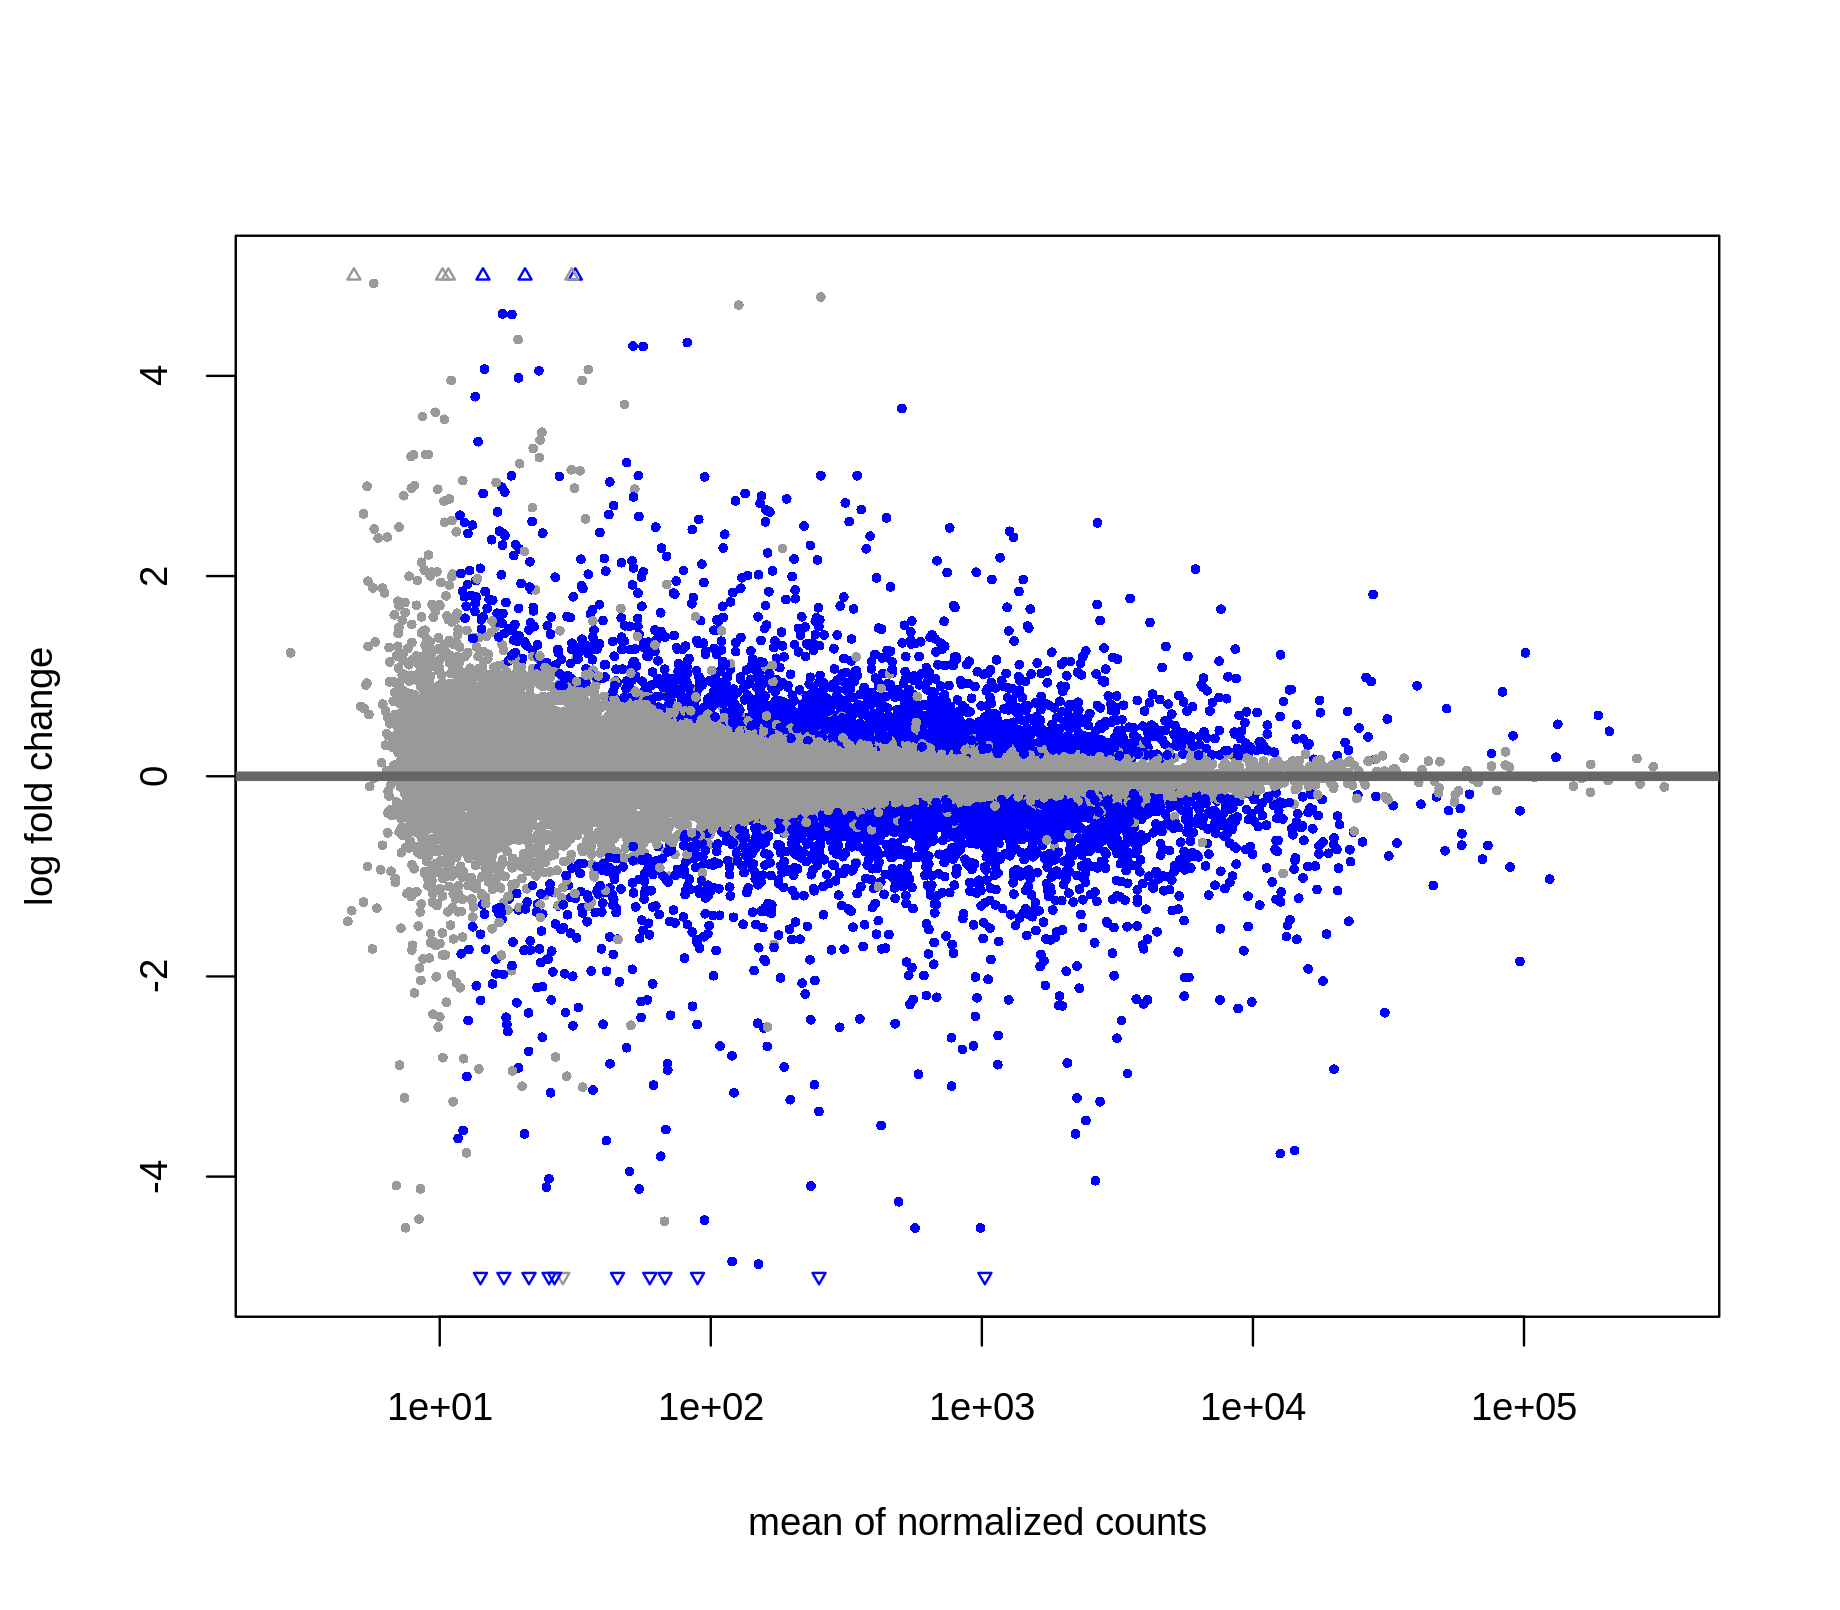

In [33]:
res.noshr <- results(dds, name="dex_untrt_vs_trt")
plotMA(res.noshr, ylim = c(-5, 5))

Для вывода графика с указанием положения на нем гена CRISPLD2, введите код:

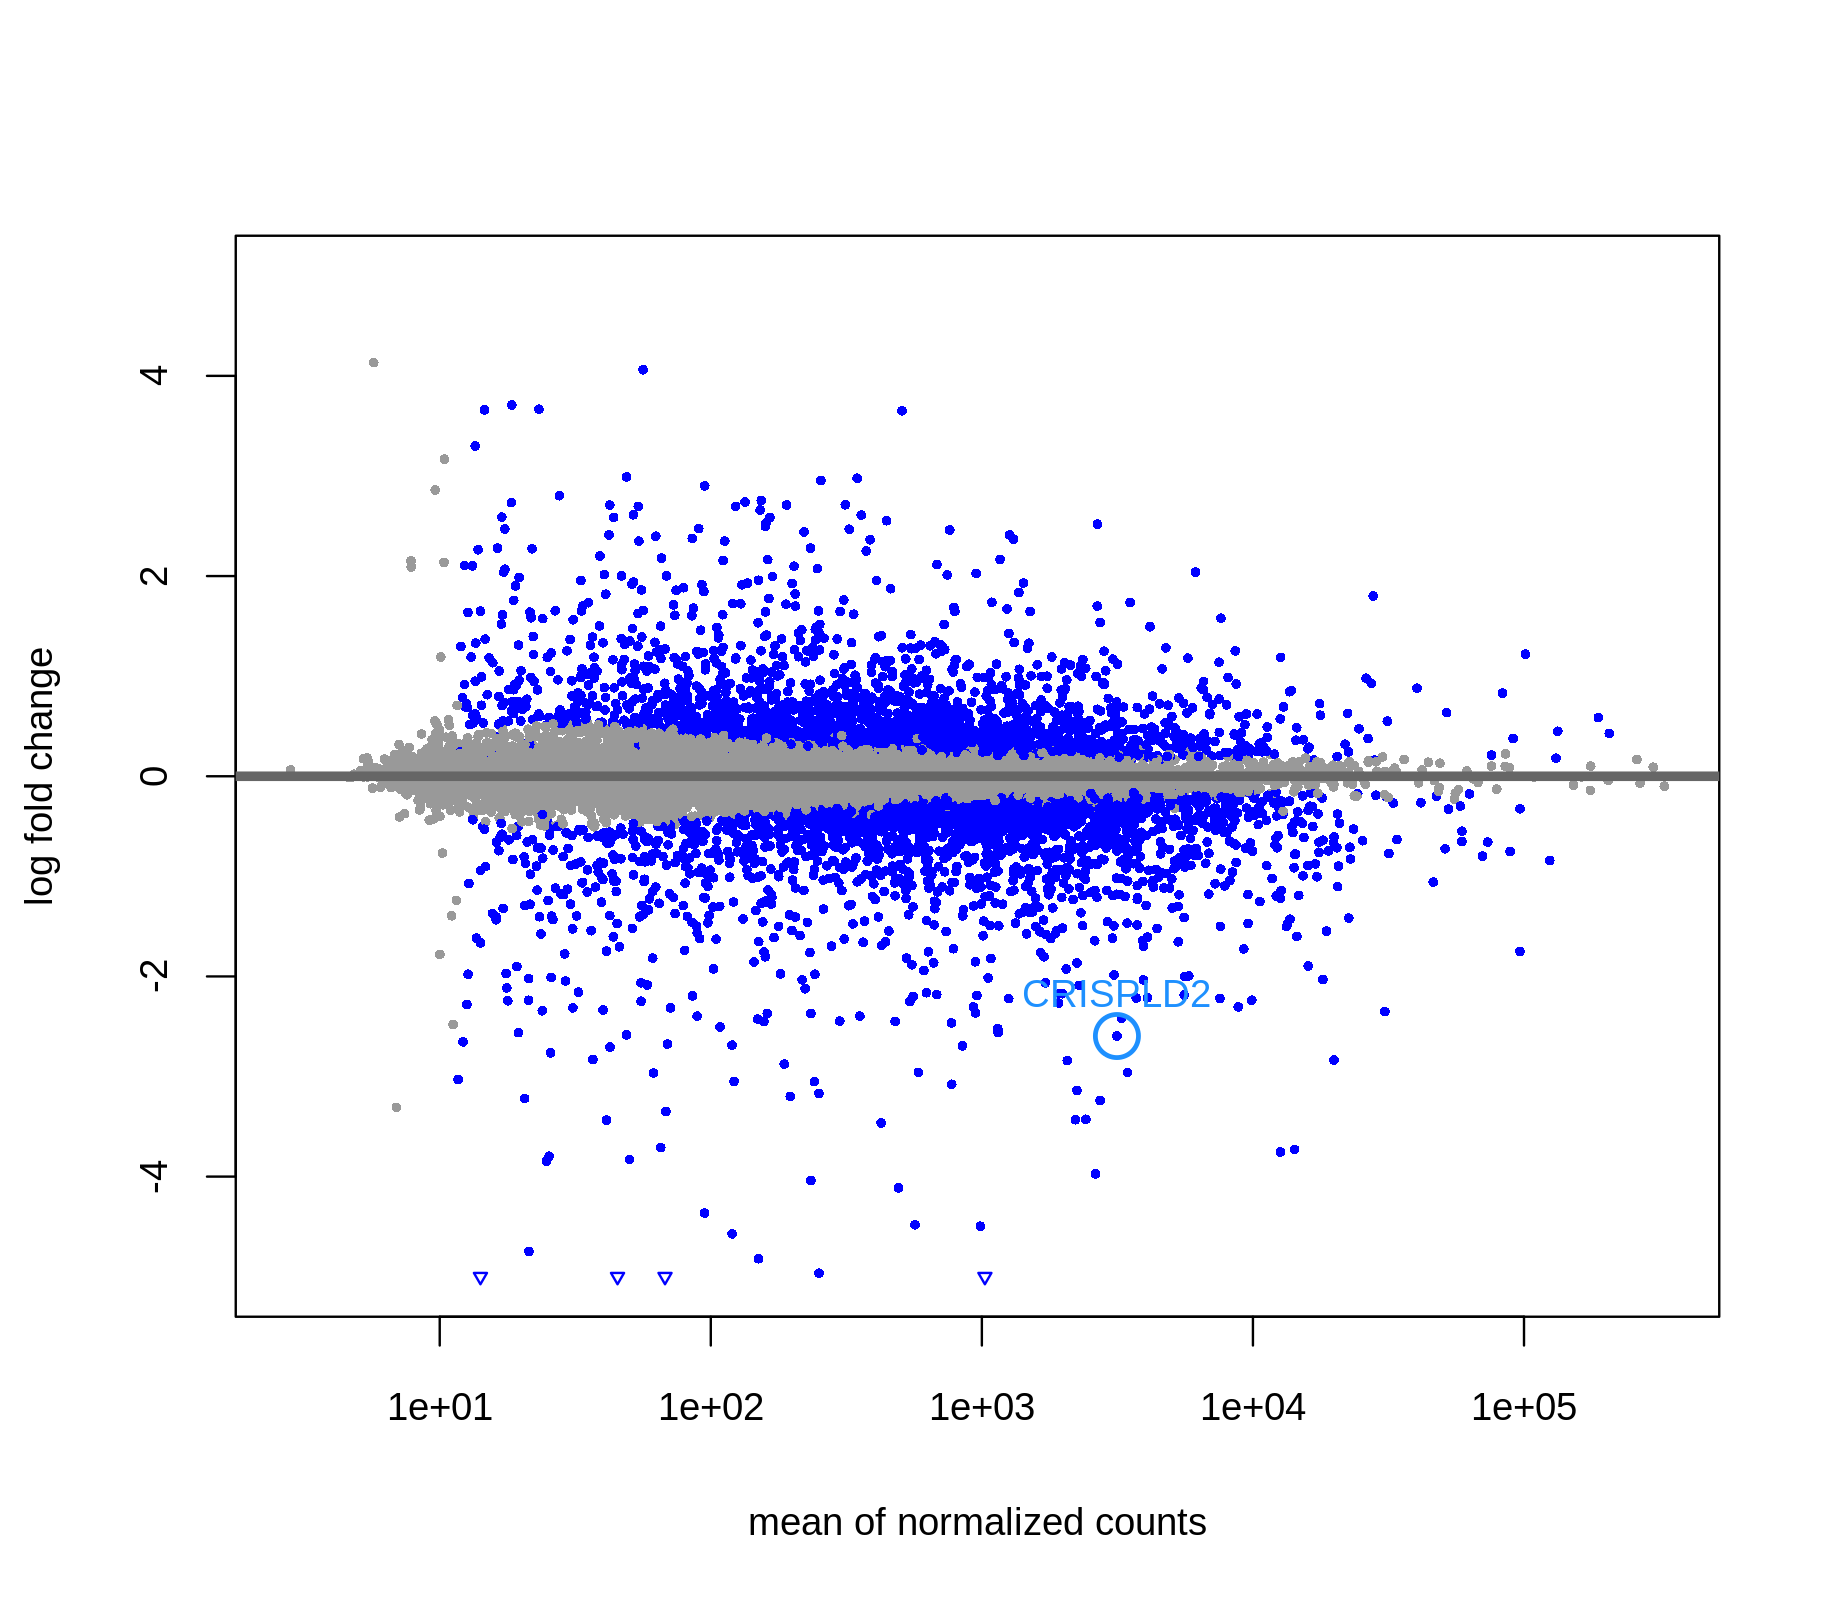

In [34]:
plotMA(res, ylim = c(-5,5))
with(res["ENSG00000103196.12", ], {
  points(baseMean, log2FoldChange, col="dodgerblue", cex=2, lwd=2)
  text(baseMean, log2FoldChange, "CRISPLD2", pos=3, col="dodgerblue")
})

### Задание № 2:

1. Постройте график с указанием гена RGCC (regulator of cell cycle)
2. Как реагирует этот ген при обработке клеток дексаметазолом?

**Ответы:**

1) Построим график:

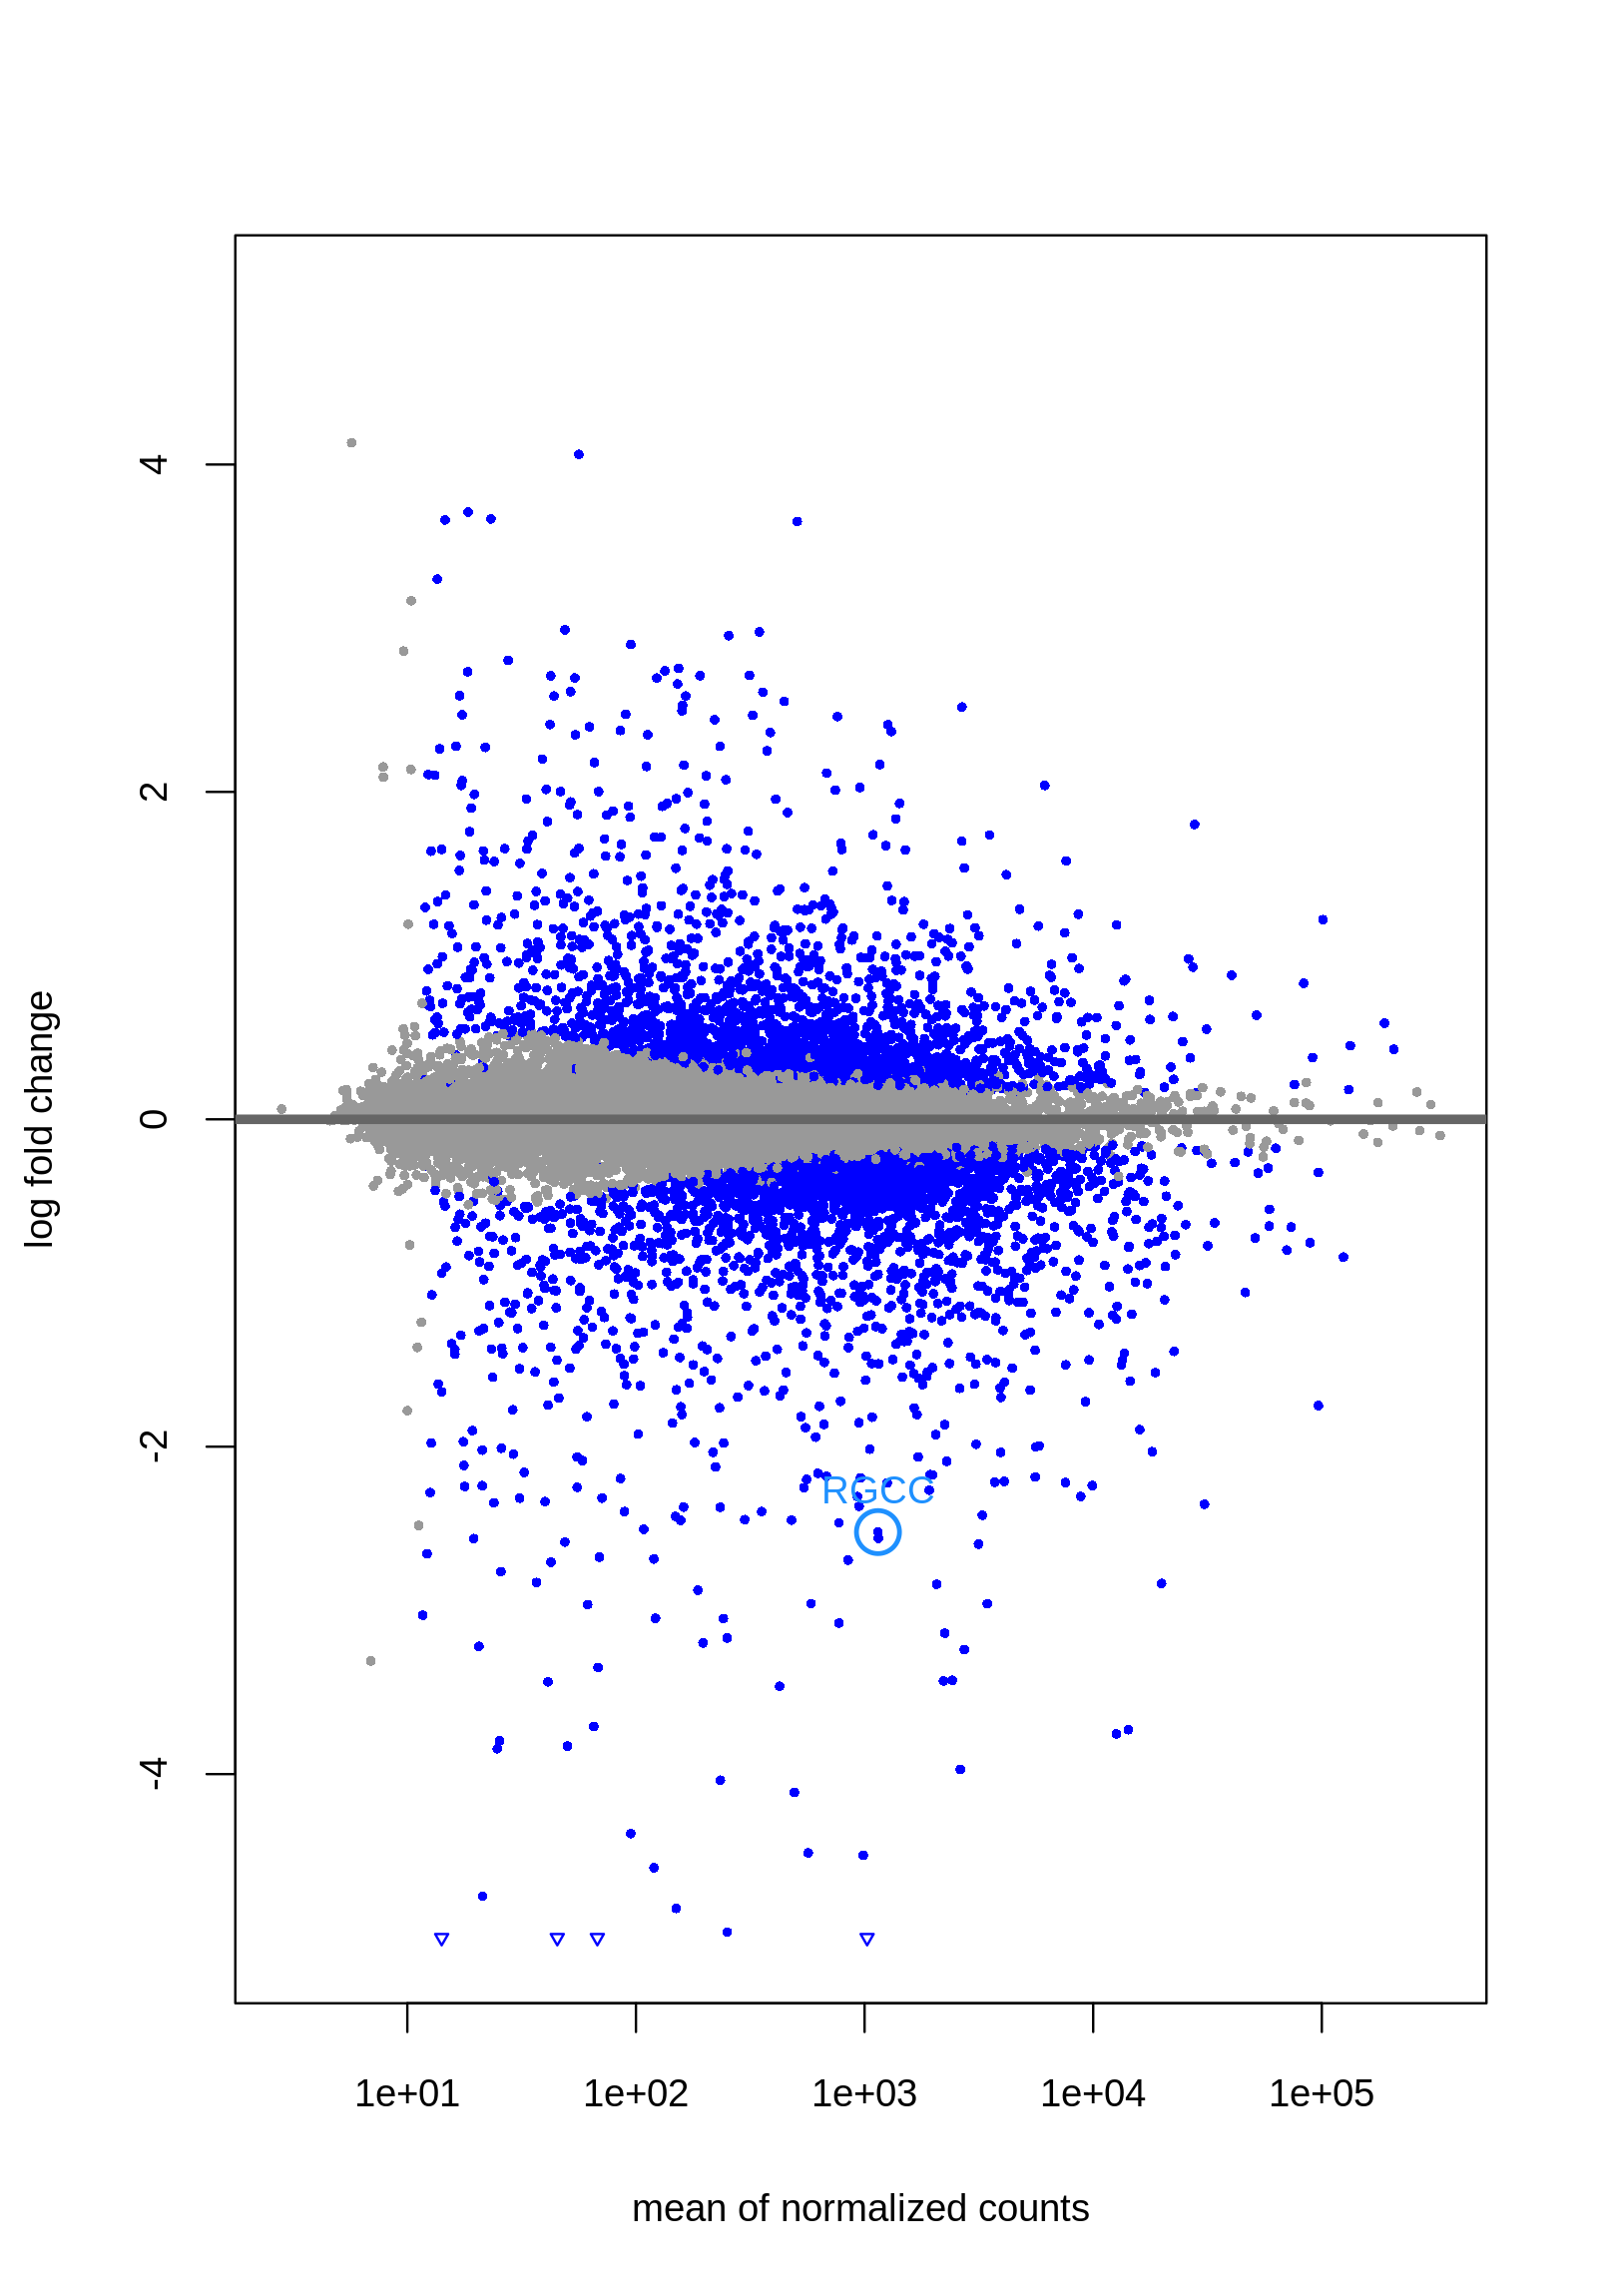

In [38]:
plotMA(res, ylim = c(-5,5))
with(res["ENSG00000102760", ], {
  points(baseMean, log2FoldChange, col="dodgerblue", cex=2, lwd=2)
  text(baseMean, log2FoldChange, "RGCC", pos=3, col="dodgerblue")
})

2) Значение log fold change < 0 для этого гена, что означает, что экспрессия уменьшилась, поскольку это логарифм от отношения "новая экспрессия / старая экспрессия", а раз логарифм < 0, значит, новая экспрессия < старой.

---

Еще один полезный диагностический график - это гистограмма значений p value. Этот график лучше всего сформировать, исключив гены с очень маленькими значениями p, которые в противном случае генерируют выбросы на гистограмме.

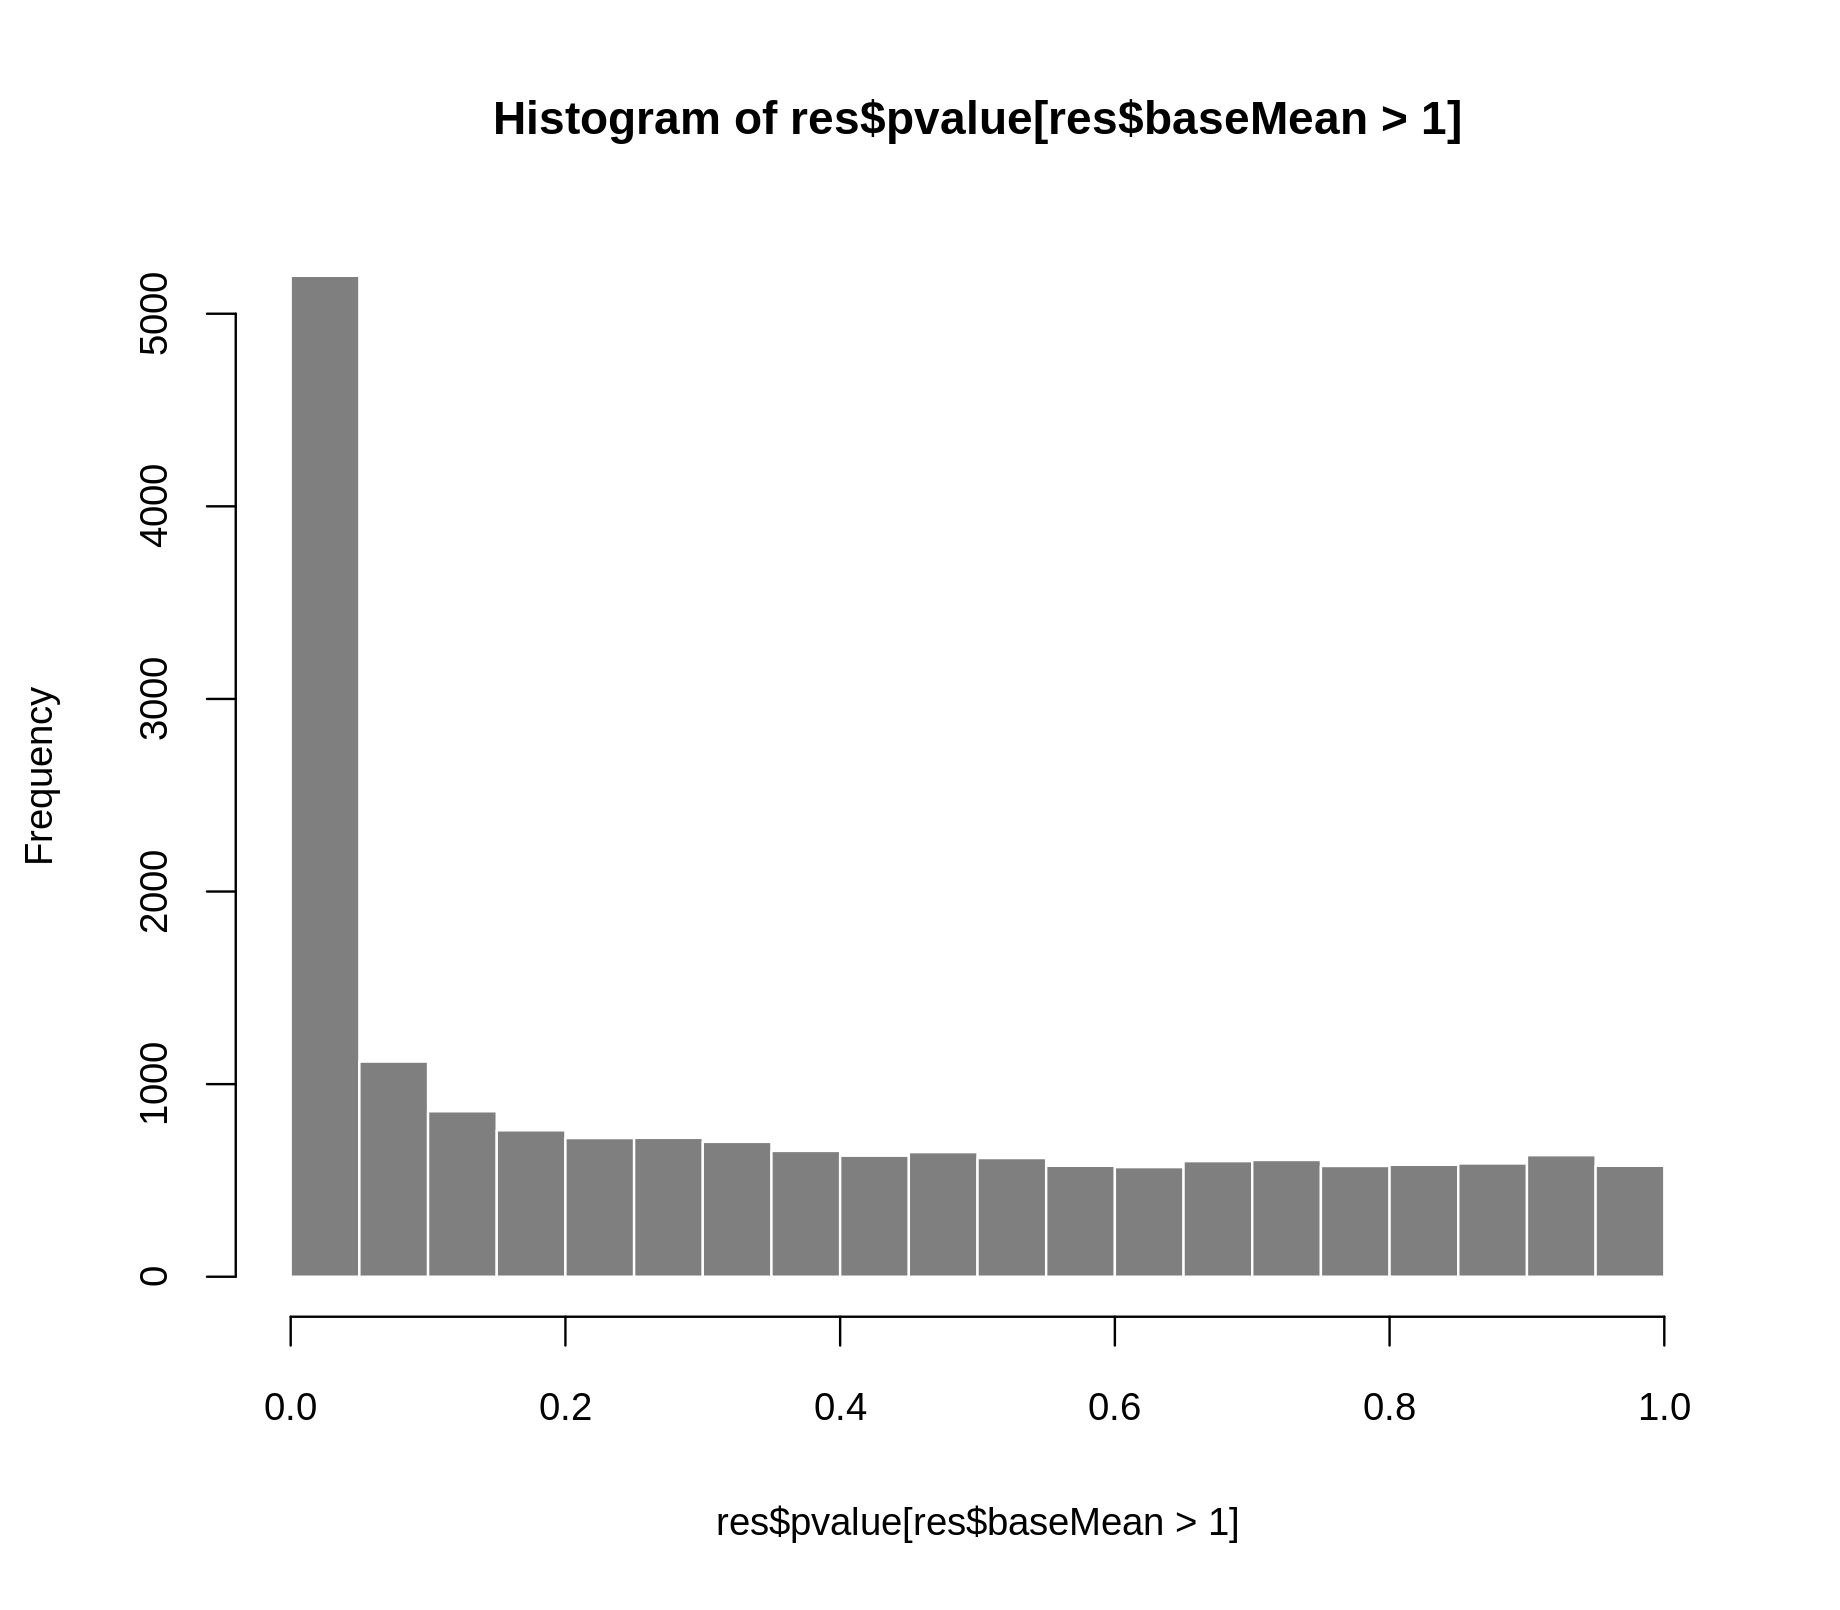

In [36]:
hist(res$pvalue[res$baseMean > 1], breaks = 0:20/20,
     col = "grey50", border = "white")

---

## 3.4. Кластеризация генов с дифференциальной экспрессией

Построим тепловую карту 20 генов, которые несут высокий сигнал. Дендрограмма сбоку показывает нам иерархическую кластеризацию генов. Тепловая карта является более актуальной, если мы смотрим не на абсолютную величину экспрессии, а на величину, на которую каждый ген отклоняется для каждой клетки от среднего значения гена для всех образцов. Следовательно, мы должны объединить значения каждого гена и расчитать долю экспрессии для каждого эксперимента.

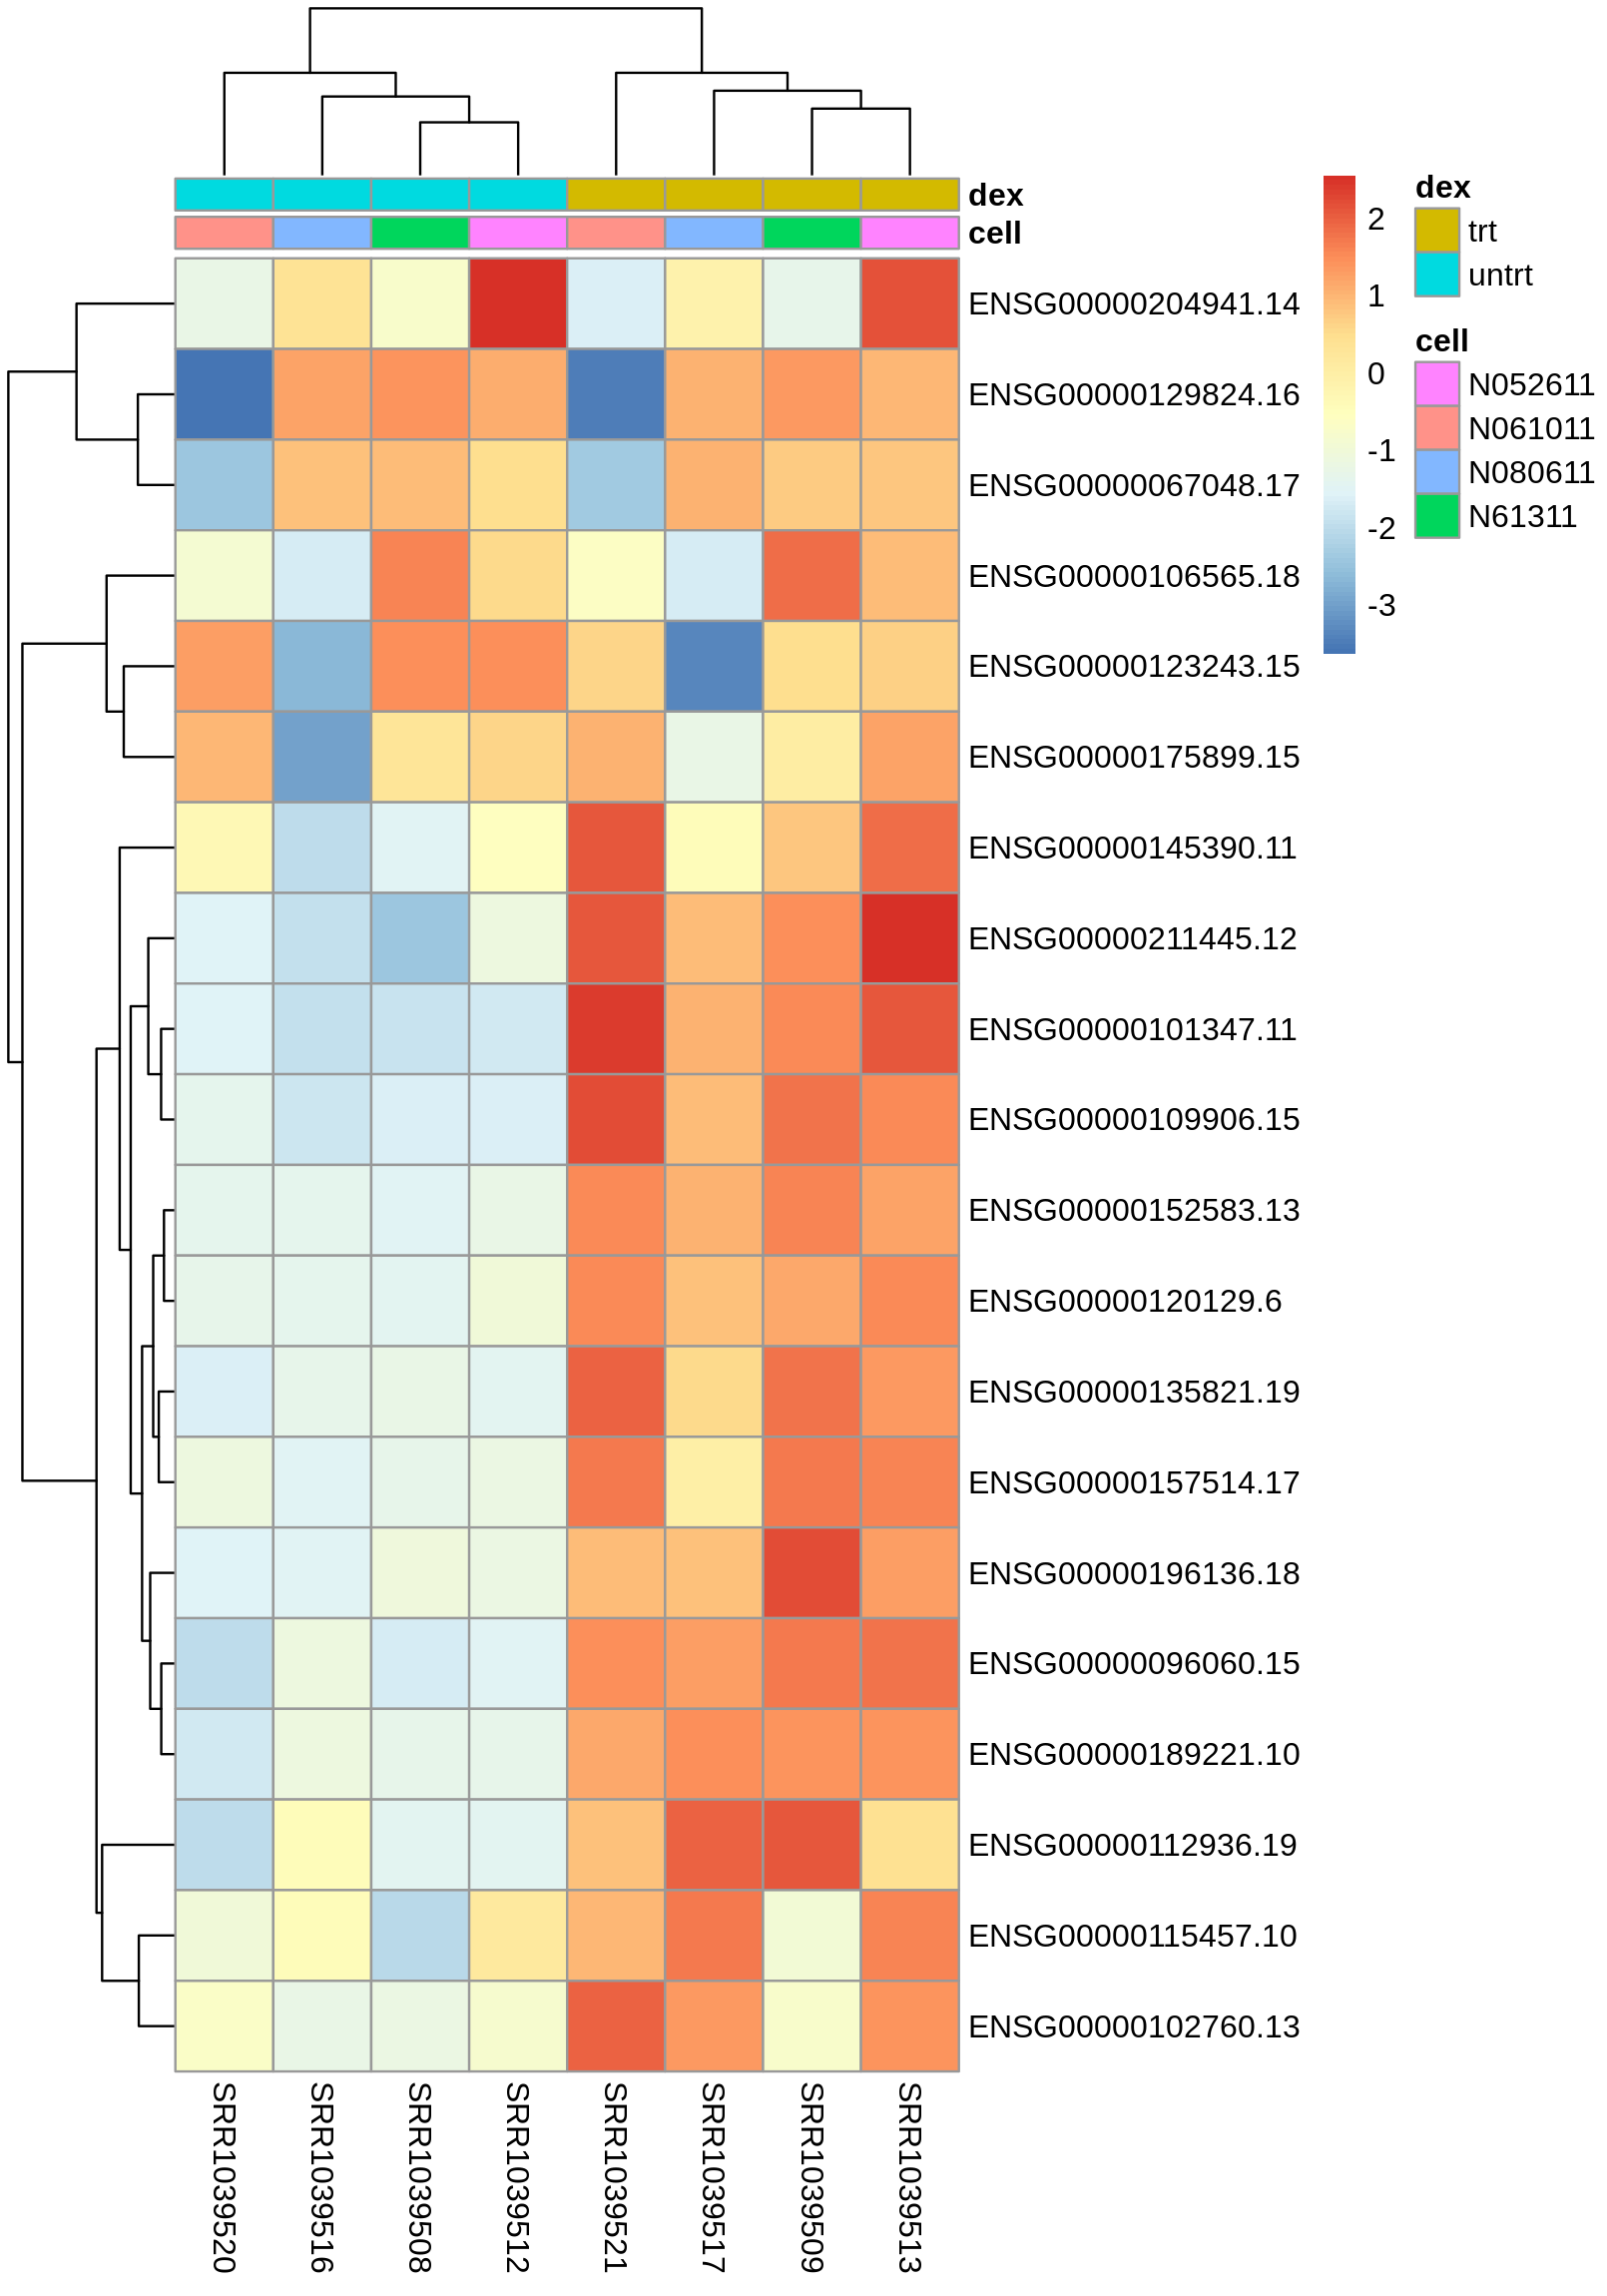

In [37]:
library("genefilter")
library("pheatmap")
options(repr.plot.width=7, repr.plot.height=10, repr.plot.res=230, repr.plot.pointsize=15, repr.plot.quality=100)
topVarGenes <- head(order(rowVars(assay(vsd)), decreasing = TRUE), 20)
mat  <- assay(vsd)[ topVarGenes, ]
mat  <- mat - rowMeans(mat)
anno <- as.data.frame(colData(vsd)[, c("cell","dex")])
pheatmap(mat, annotation_col = anno)

### Задание №3:

1. Сделайте подобный график с нормализованными данными методом rlog
2. Опишите наблюдаемые различия

**Ответы:**

1) Построим график по rld:

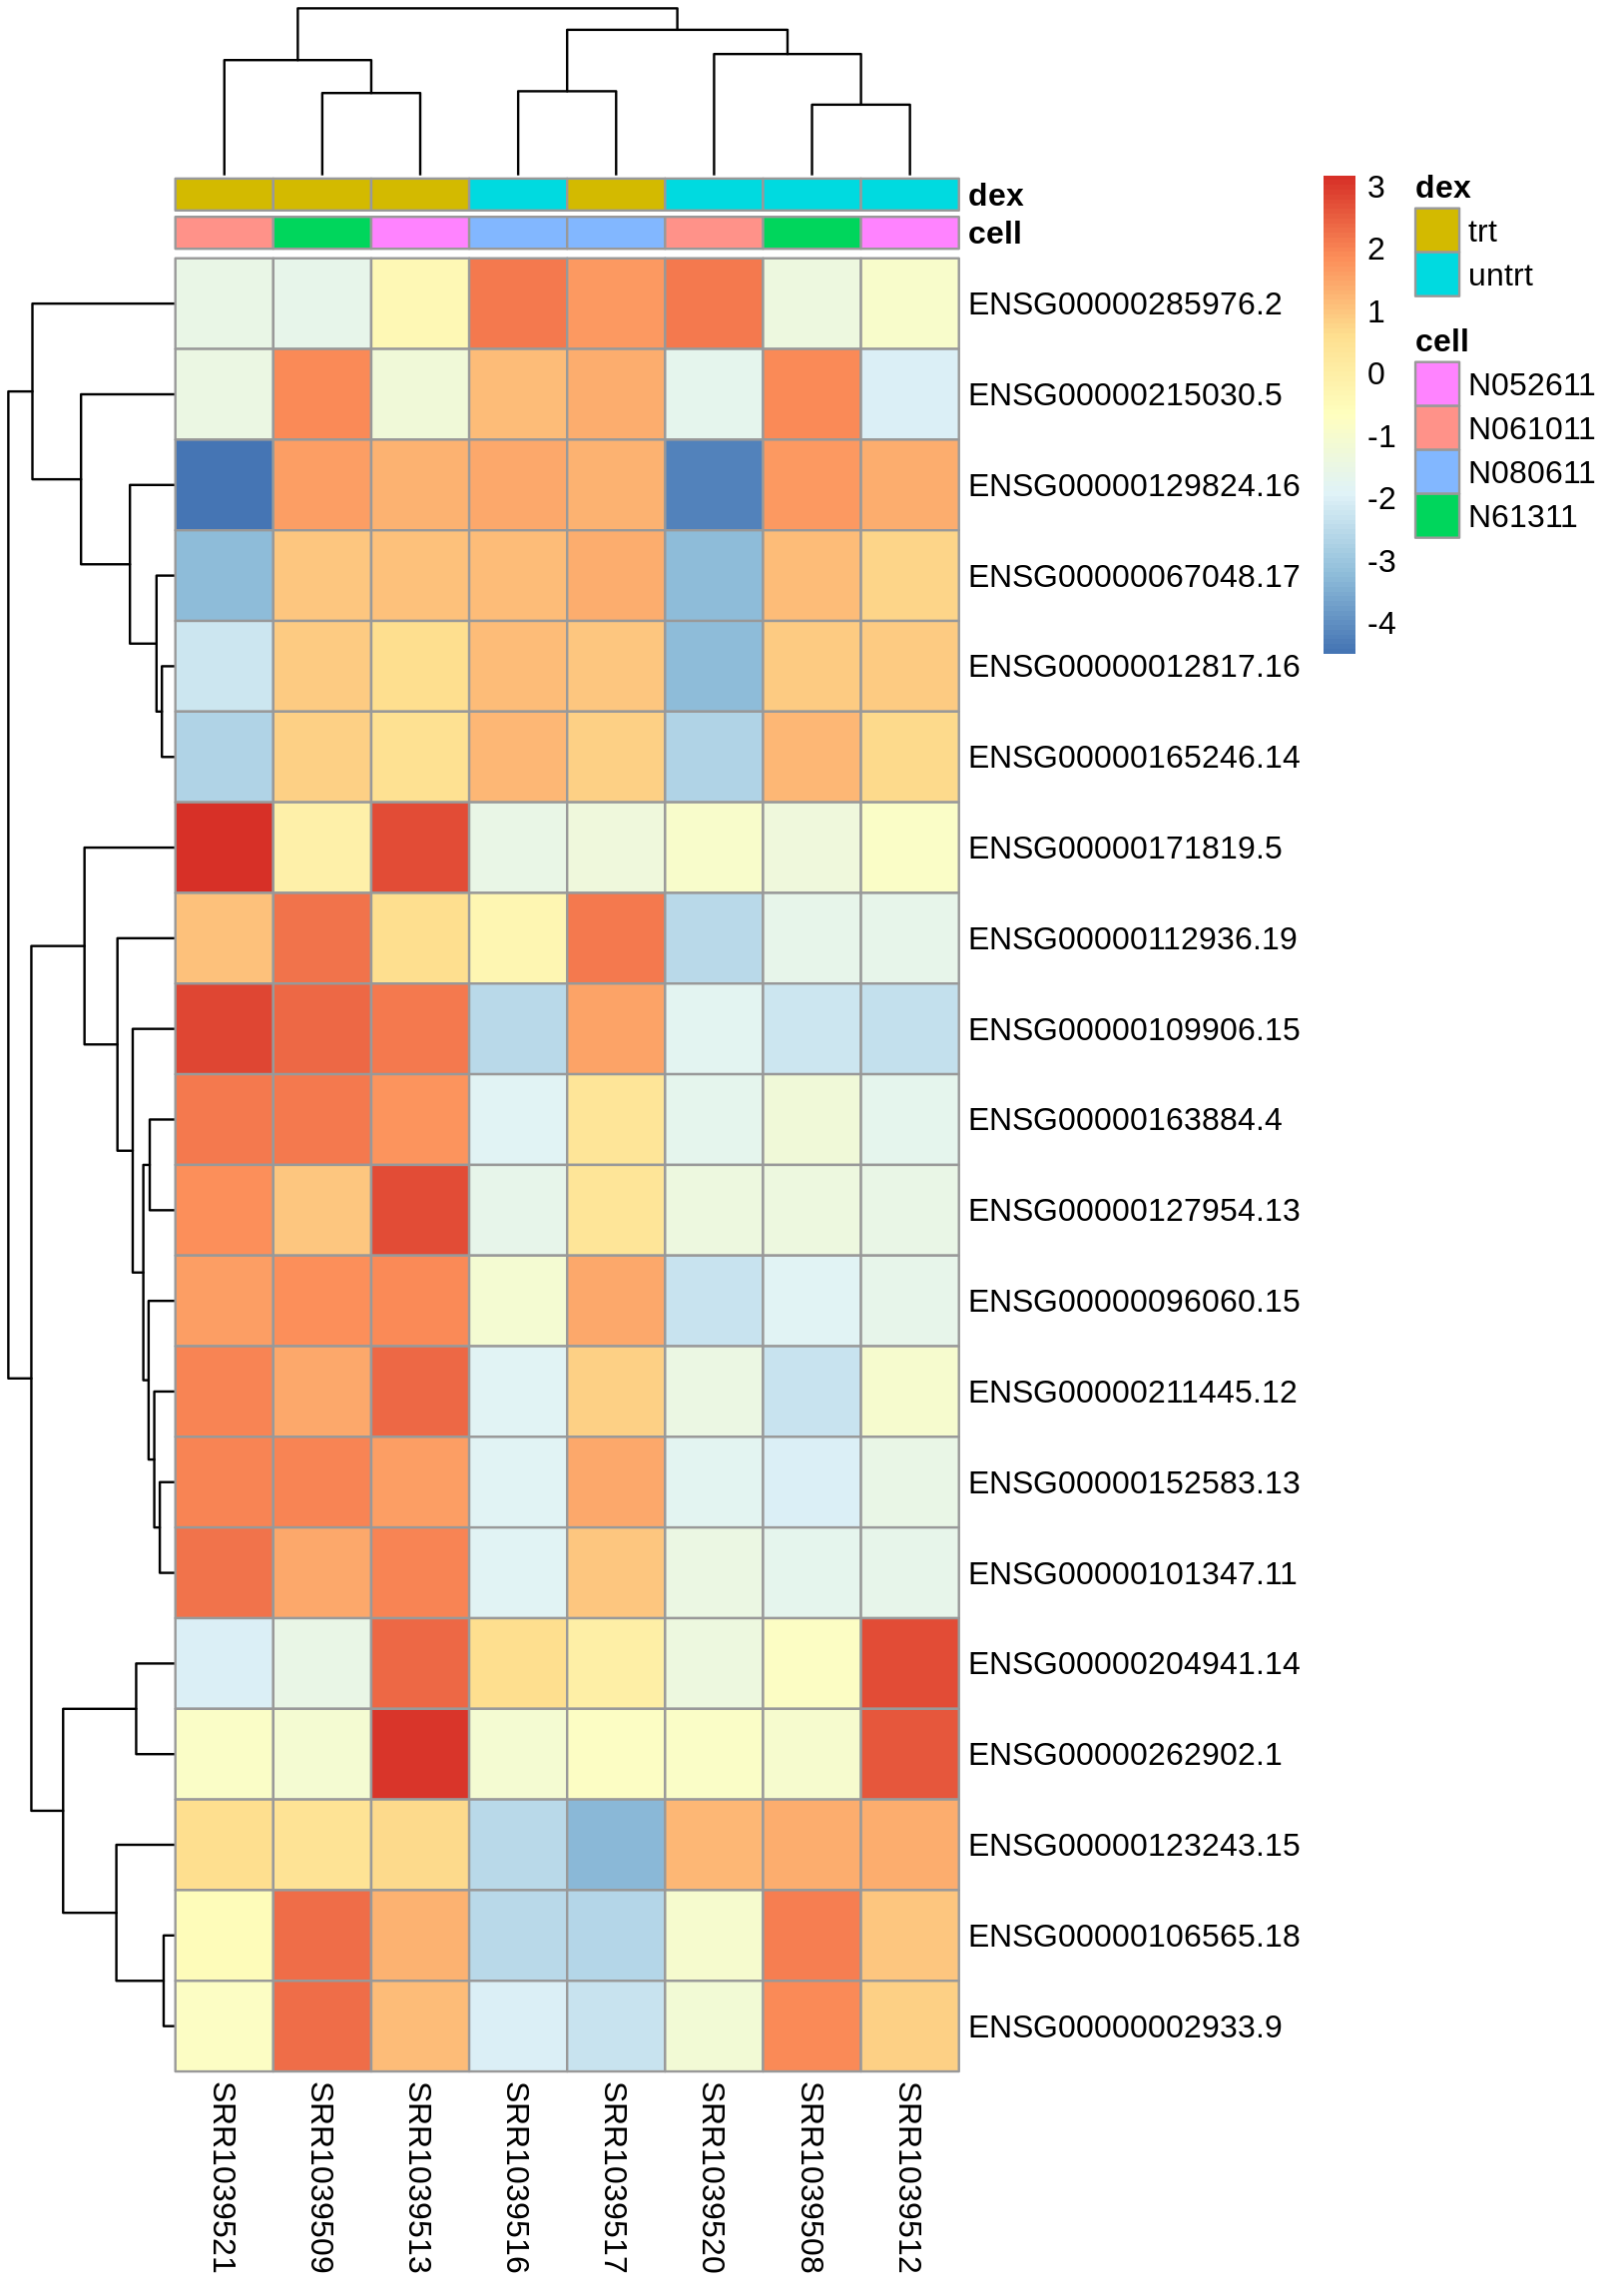

In [40]:
library("genefilter")
library("pheatmap")
options(repr.plot.width=7, repr.plot.height=10, repr.plot.res=230, repr.plot.pointsize=15, repr.plot.quality=100)
topVarGenes <- head(order(rowVars(assay(rld)), decreasing = TRUE), 20)
mat  <- assay(rld)[ topVarGenes, ]
mat  <- mat - rowMeans(mat)
anno <- as.data.frame(colData(rld)[, c("cell","dex")])
pheatmap(mat, annotation_col = anno)

2) Заметим, что на vsd клеточные линии образуют два четких кластера (обработанные и необработанные), в том время как на rld кластеры несколько перемешались, что мы наблюдали на предыдущем графике, где клеточные линии-квадратики обособились от кластеров. 

---

## 3.5. Аннотация дифференциально экспрессируемых генов

Наша таблица результатов пока содержит только идентификаторы генов Ensembl, но альтернативные названия генов могут быть более информативными для интерпретации. Для их получения загрузим пакет AnnotationDbi и пакет аннотаций для генома человека org.Hs.eg.db:

In [41]:
library("AnnotationDbi")
library("org.Hs.eg.db")

In [42]:
resGR <- lfcShrink(dds, coef="dex_untrt_vs_trt", type="apeglm", format="GRanges")

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



Создадим новый столбец в результатах с отображением символов (symbol) по каждому гену:

In [43]:
ens.str <- substr(rownames(res), 1, 15)
res$symbol <- mapIds(org.Hs.eg.db,
                     keys=ens.str,
                     column="SYMBOL",
                     keytype="ENSEMBL",
                     multiVals="first")
res$entrez <- mapIds(org.Hs.eg.db,
                     keys=ens.str,
                     column="ENTREZID",
                     keytype="ENSEMBL",
                     multiVals="first")
ens.str <- substr(names(resGR), 1, 15)
resGR$symbol <- mapIds(org.Hs.eg.db, ens.str, "SYMBOL", "ENSEMBL")
head((resGR$symbol),n=30)

'select()' returned 1:many mapping between keys and columns

'select()' returned 1:many mapping between keys and columns

'select()' returned 1:many mapping between keys and columns



ENSG00000000003 ENSG00000000419 ENSG00000000457 ENSG00000000460 ENSG00000000971 
       "TSPAN6"          "DPM1"         "SCYL3"      "C1orf112"           "CFH" 
ENSG00000001036 ENSG00000001084 ENSG00000001167 ENSG00000001460 ENSG00000001461 
        "FUCA2"          "GCLC"          "NFYA"         "STPG1"        "NIPAL3" 
ENSG00000001497 ENSG00000001561 ENSG00000001617 ENSG00000001629 ENSG00000001630 
        "LAS1L"         "ENPP4"        "SEMA3F"        "ANKIB1"       "CYP51A1" 
ENSG00000001631 ENSG00000002016 ENSG00000002330 ENSG00000002549 ENSG00000002586 
        "KRIT1"         "RAD52"           "BAD"          "LAP3"          "CD99" 
ENSG00000002746 ENSG00000002822 ENSG00000002834 ENSG00000002919 ENSG00000002933 
        "HECW1"        "MAD1L1"         "LASP1"         "SNX11"      "TMEM176A" 
ENSG00000003056 ENSG00000003096 ENSG00000003137 ENSG00000003249 ENSG00000003393 
         "M6PR"        "KLHL13"       "CYP26B1"        "DBNDD1"          "ALS2"

---

## 3.6. Анализ результатов с учетом аннотации генов

Мы можем отобразить участок генома, в котором будут указаны гены с наибольшей разницей в экспрессии:

In [44]:
library("Gviz")
window <- resGR[topGene] + 1e6
strand(window) <- "*"
resGRsub <- resGR[resGR %over% window]
naOrDup <- is.na(resGRsub$symbol) | duplicated(resGRsub$symbol)
resGRsub$group <- ifelse(naOrDup, names(resGRsub), resGRsub$symbol)
status <- factor(ifelse(resGRsub$padj < 0.05 & !is.na(resGRsub$padj), "sig", "notsig"))

Loading required package: grid



Затем мы можем создать дорожку генома с указанием имен генов
Если экспрессия значительно изменяется (p < 0.1) гены будут иметь розовую окраску и отображаться на графике:

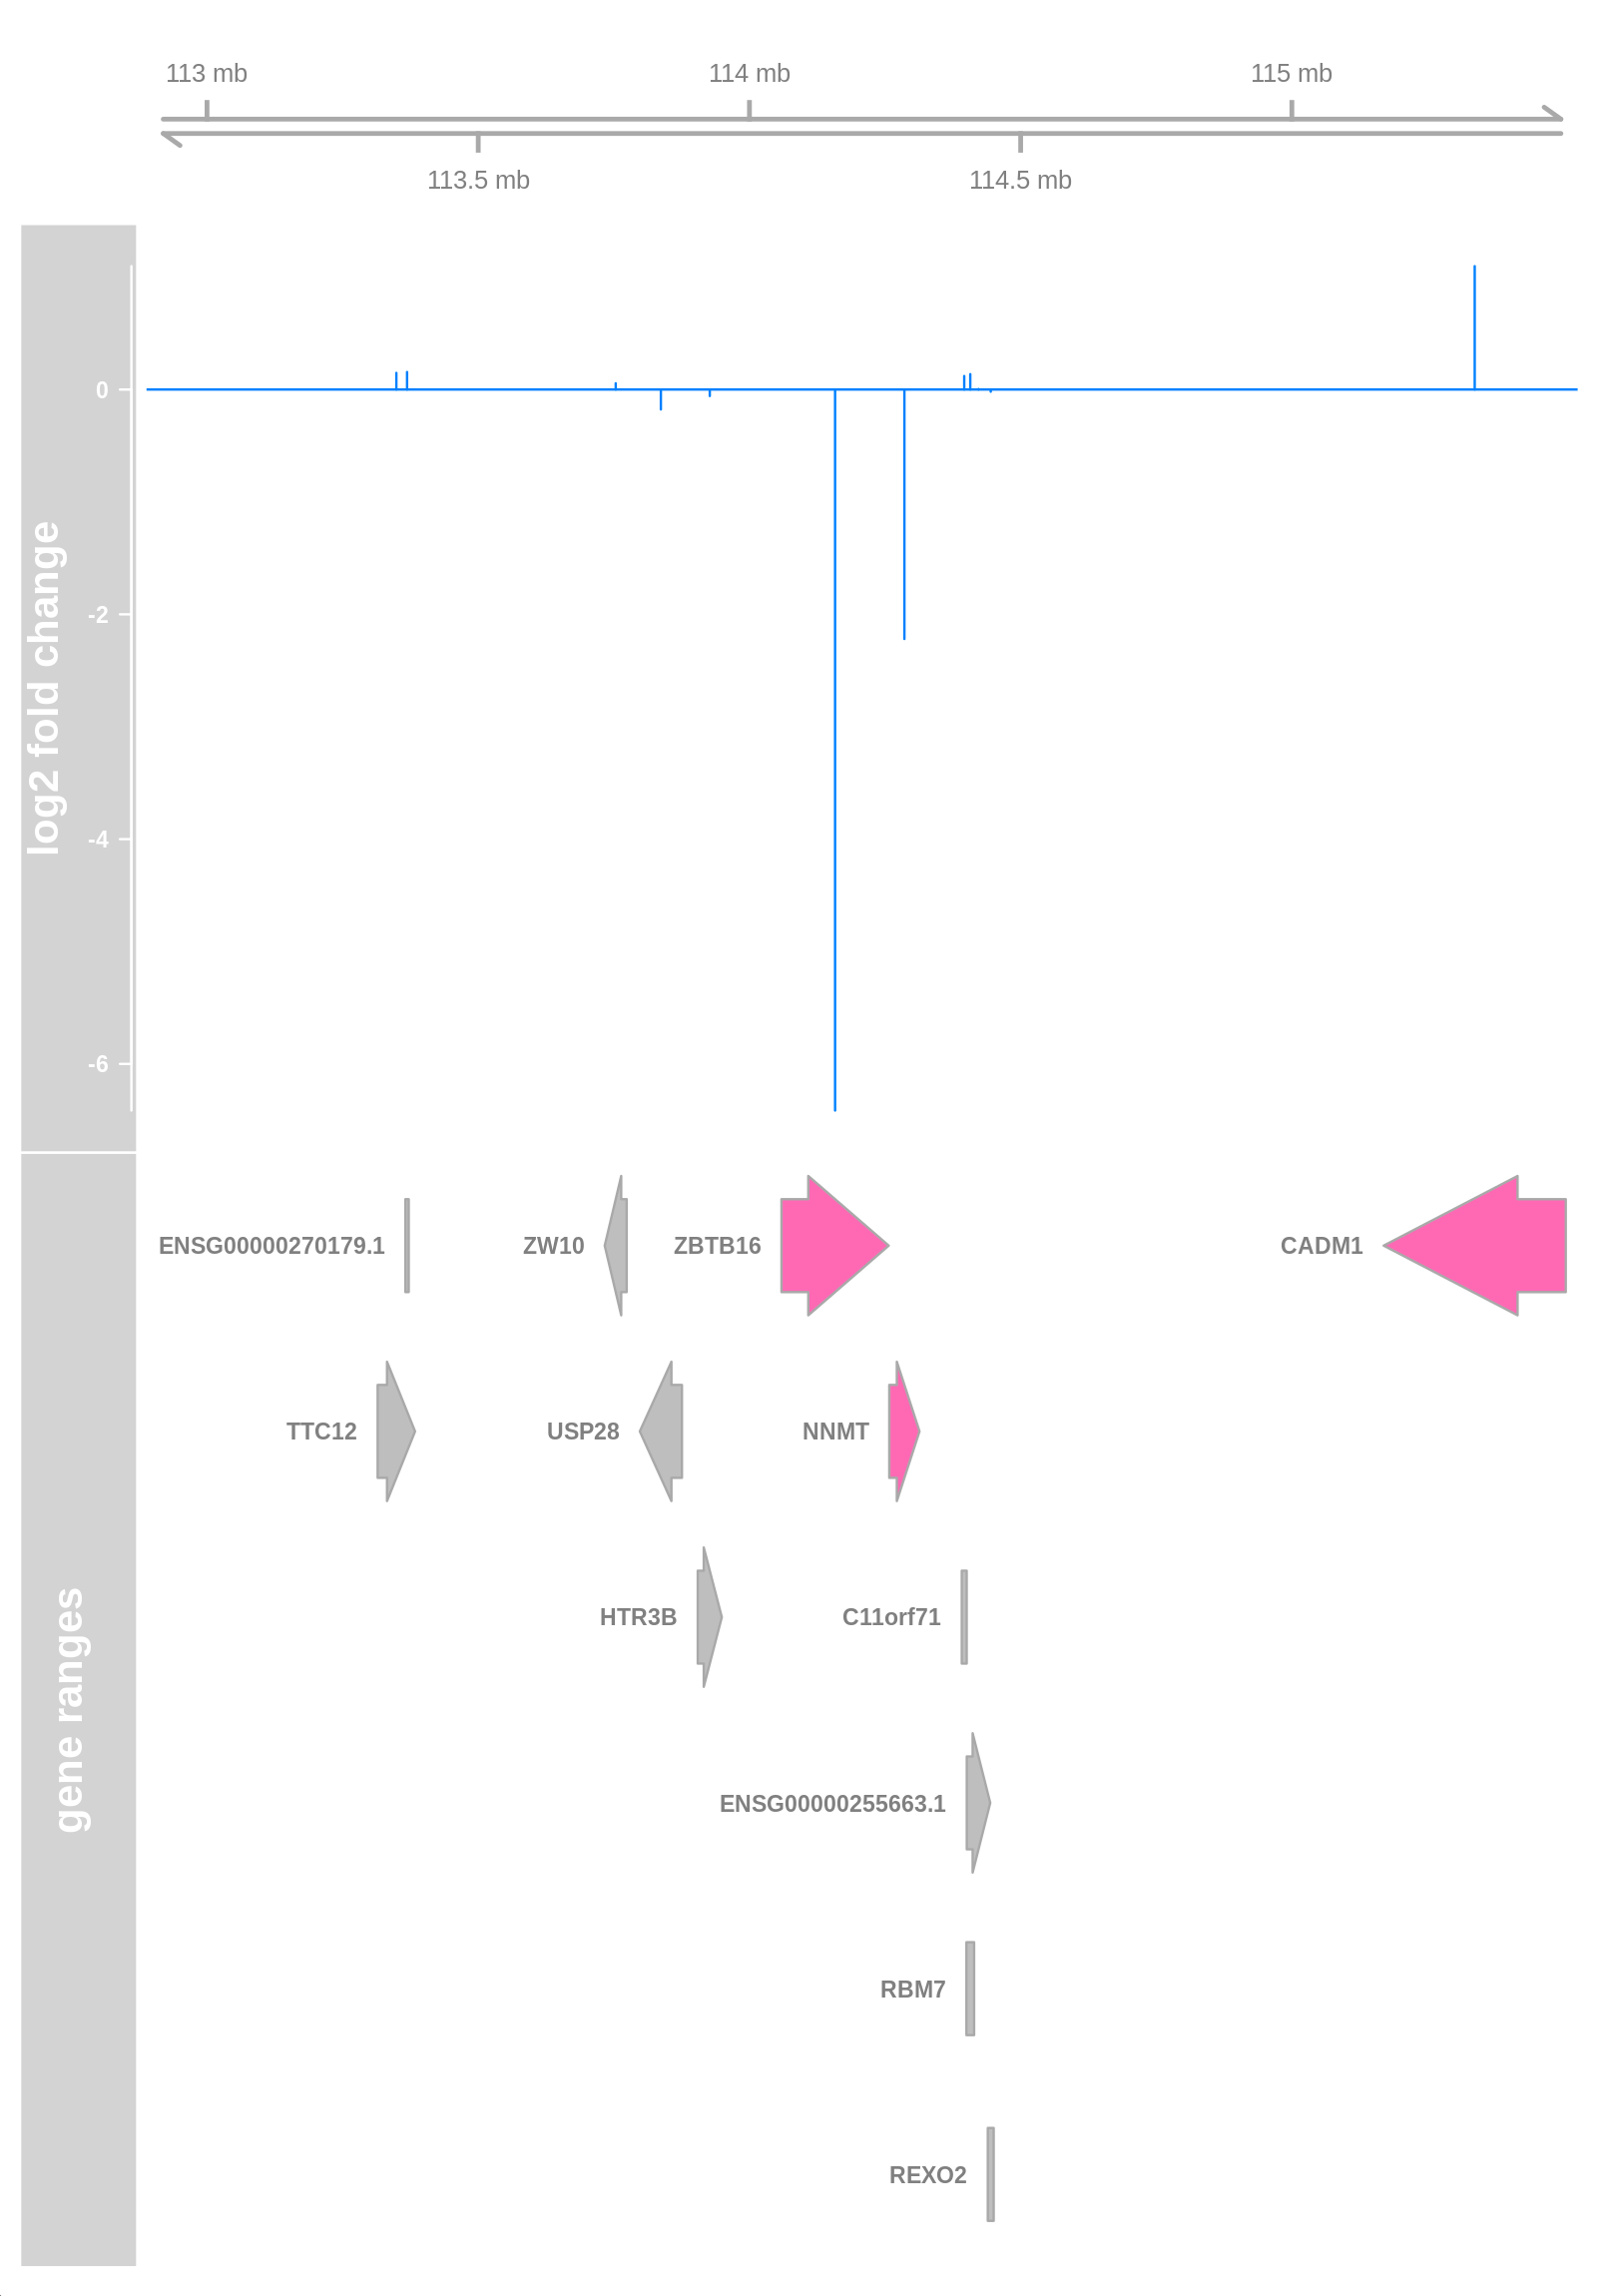

In [45]:
options(ucscChromosomeNames = FALSE)
g <- GenomeAxisTrack()
a <- AnnotationTrack(resGRsub, name = "gene ranges", feature = status)
d <- DataTrack(resGRsub, data = "log2FoldChange", baseline = 0,
               type = "h", name = "log2 fold change", strand = "+")
plotTracks(list(g, d, a), groupAnnotation = "group",
           notsig = "grey", sig = "hotpink")

### Задание №4:

1. Выведете первые 10 генов с наибольшей дифференциальной экспрессией

**Ответы:**

1) Посортим и выведем первые 10 генов:

In [52]:
topVarGenes <- head(order(rowVars(assay(vsd)), decreasing = TRUE), 10)

In [53]:
resGR$symbol[topVarGenes]

ENSG00000129824 ENSG00000211445 ENSG00000101347 ENSG00000123243 ENSG00000109906 
       "RPS4Y1"          "GPX3"        "SAMHD1"         "ITIH5"        "ZBTB16" 
ENSG00000096060 ENSG00000112936 ENSG00000204941 ENSG00000135821 ENSG00000067048 
        "FKBP5"            "C7"          "PSG5"          "GLUL"         "DDX3Y"